# Zillow Clustering Project 

Objective 

#Executive Summary 

In [118]:
#Imports Utilized
import acquire_data as a 




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing

from scipy import stats

from sklearn.metrics import mean_squared_error

from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr, spearmanr

# import visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math



from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


# import modeling tools
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score




In [ ]:
#Acquiring the Data:

In [8]:

zillow_df = a.get_all_zillow_data()

In [9]:
# create list of single unit propertylandusedesc
single_unit_props = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
zillow_df = zillow_df[zillow_df.propertylandusedesc.isin(single_unit_props)]
zillow_df = zillow_df[(zillow_df.bedroomcnt > 0) & (zillow_df.bedroomcnt <= 10)]
zillow_df = zillow_df[(zillow_df.bathroomcnt > 0) & (zillow_df.bathroomcnt <= 10)]


Checking Out the Nulls:

In [11]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    print(type(num_missing))
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    return rows_missing



def get_nulls(df):
    col =  nulls_by_col(df)
    row =  nulls_by_row(df)
    
    return col, row


get_nulls(zillow_df)


<class 'pandas.core.series.Series'>


(                        num_rows_missing  percent_rows_missing
 typeconstructiontypeid             71213             99.687832
 storytypeid                        71389             99.934207
 propertylandusetypeid                  0              0.000000
 heatingorsystemtypeid              25003             35.000560
 buildingclasstypeid                71436            100.000000
 ...                                  ...                   ...
 buildingclassdesc                  71436            100.000000
 heatingorsystemdesc                25003             35.000560
 propertylandusedesc                    0              0.000000
 storydesc                          71389             99.934207
 typeconstructiondesc               71213             99.687832
 
 [69 rows x 2 columns],
    num_cols_missing percent_cols_missing  num_rows
 0                23    33.33333333333333         2
 1                24    34.78260869565217        13
 2                25   36.231884057971016        2

In [12]:
#Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df:
zillow_df = zillow_df.replace(r'^\s*S', np.nan, regex=True)
zillow_df = zillow_df.drop_duplicates()

In [13]:
def drop_columns(df, col_list):
    '''
    This function takes in a pandas DataFrame, and a list of columns to drop,
    and returns a DataFrame after dropping the columns
    '''
    # This list needs to be updated for each DataFrame
 #    col_list = ['propertylandusetypeid', 'id', 'finishedsquarefeet12', 'propertycountylandusecode', 'transactiondate', 'propertylandusedesc', 'censustractandblock', 'regionidcity', 'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
 # 'landtaxvaluedollarcnt', 'rawcensustractandblock']
    
    df = df.drop(columns=col_list)
    df = df.drop(columns=(df.filter(regex='typeid').columns))
    df = df.drop(columns=(df.filter(regex='regionid').columns))
    return df


col_list = ['id', 'transactiondate',
            'id.1', 'propertycountylandusecode', 'rawcensustractandblock',
            'assessmentyear', 'roomcnt', 'calculatedbathnbr', 'finishedsquarefeet12']

#Dropping id columns, established as unnecessary
#Dropping type_id columns, established as unnecessary
#Dropping all region id columns, using fips for possible region features
#Droppung columns with information, provided in more contextual columns 


zillow_df = drop_columns(zillow_df, col_list)

In [14]:
def drop_cols_null(df, max_missing_rows_pct=0.25):
    '''
    Takes in a DataFrame and a maximum percent for missing values and
    returns the passed DataFrame after removing any colums missing the
    defined max percent or more worth of rows
    '''
    
    # set threshold for axis=1 and drop cols
    thresh_col = math.ceil(df.shape[0] * (1 - max_missing_rows_pct))
    df = df.dropna(axis=1, thresh=thresh_col)

    return df


def drop_rows_null(df, max_missing_cols_pct=0.25):
    '''
    Takes in a DataFrame and a maximum percent for missing values and
    returns the passed DataFrame after removing any rows missing the
    defined max percent or more worth of columns
    '''
    
    # set threshold for axis=0 and drop rows
    thresh_row = math.ceil(df.shape[1] * (1 - max_missing_cols_pct))
    df = df.dropna(axis=0, thresh=thresh_row)
    
    return df

def drop_null_values(df, max_missing_rows_pct=0.25, max_missing_cols_pct=0.25):
    '''
    Takes in a DataFrame and maximum percents for missing values in
    columns and rows and returns the passed DataFrame after first
    removing any columns missing the defined max percent or more worth
    of rows then removing rows missing the defined max percent or more
    worth of columns
    '''
    
    # drop columns with null values for passed percent of rows
    df = drop_cols_null(df, max_missing_rows_pct)
    # drop rows with null values for passed percent of columns
    df = drop_rows_null(df, max_missing_cols_pct)
    
    return df

zillow_df = drop_null_values(zillow_df)

In [17]:
# drop all rows with null values for any tax fields
zillow_df = zillow_df[zillow_df.taxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.landtaxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.structuretaxvaluedollarcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.taxamount.isnull() == False]
# Dropping any rows with low count of nulls   

#dropping lotsizesquarefeet, too many nulls, 
zillow_df = zillow_df[zillow_df.fullbathcnt.isnull() == False]
zillow_df = zillow_df[zillow_df.yearbuilt.isnull() == False]
zillow_df = zillow_df[zillow_df.calculatedfinishedsquarefeet.isnull() == False]
zillow_df = zillow_df[zillow_df.censustractandblock.isnull() == False]


#Dropping these columns bc they either have too many nulls or are 
dropped = ['lotsizesquarefeet', 'fullbathcnt']
zillow_df = zillow_df.drop(columns=dropped)

In [18]:
#Renaming the Columns
zillow_df = zillow_df.rename(columns={'parcelid': 'parcel_id', 'logerror': 'target', 
                            'bathroomcnt': 'bath_count', 'bedroomcnt': 'bed_count', 
                            'calculatedfinishedsquarefeet': 'sq_footage', 
                            'censustractandblock': 'census_tract', 
                            'yearbuilt': 'year_built', 'taxvaluedollarcnt': 'property_value', 
                            'taxamount': 'tax_amount', 'structuretaxvaluedollarcnt': 'structure_value',
                            'landtaxvaluedollarcnt': 'land_value'})


In [19]:
def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df = pd.concat([df, county_df], axis = 1)
    # drop  fips columns
    df = df.drop(columns = ['fips'])
    return df

zillow_df = get_counties(zillow_df)

In [20]:

def create_features(df):
    '''
    This function is specific to my zillow clustering project. 
    It creates new feature columns to use in clustering exploration
    and modeling.
    '''
    # create age column that uses yearbuilt to show how old the property is
    # df['age'] = 2017 - df.year_built
    # create taxrate variable
    zillow_df['tax_rate'] = zillow_df.tax_amount/zillow_df.property_value*100
    # create acres variable
    
    zillow_df['latitude'] = (zillow_df['latitude']) / 1000000
    zillow_df['longitude'] = (zillow_df['longitude']) / 1000000
    
    return df


zillow_df = create_features(zillow_df)

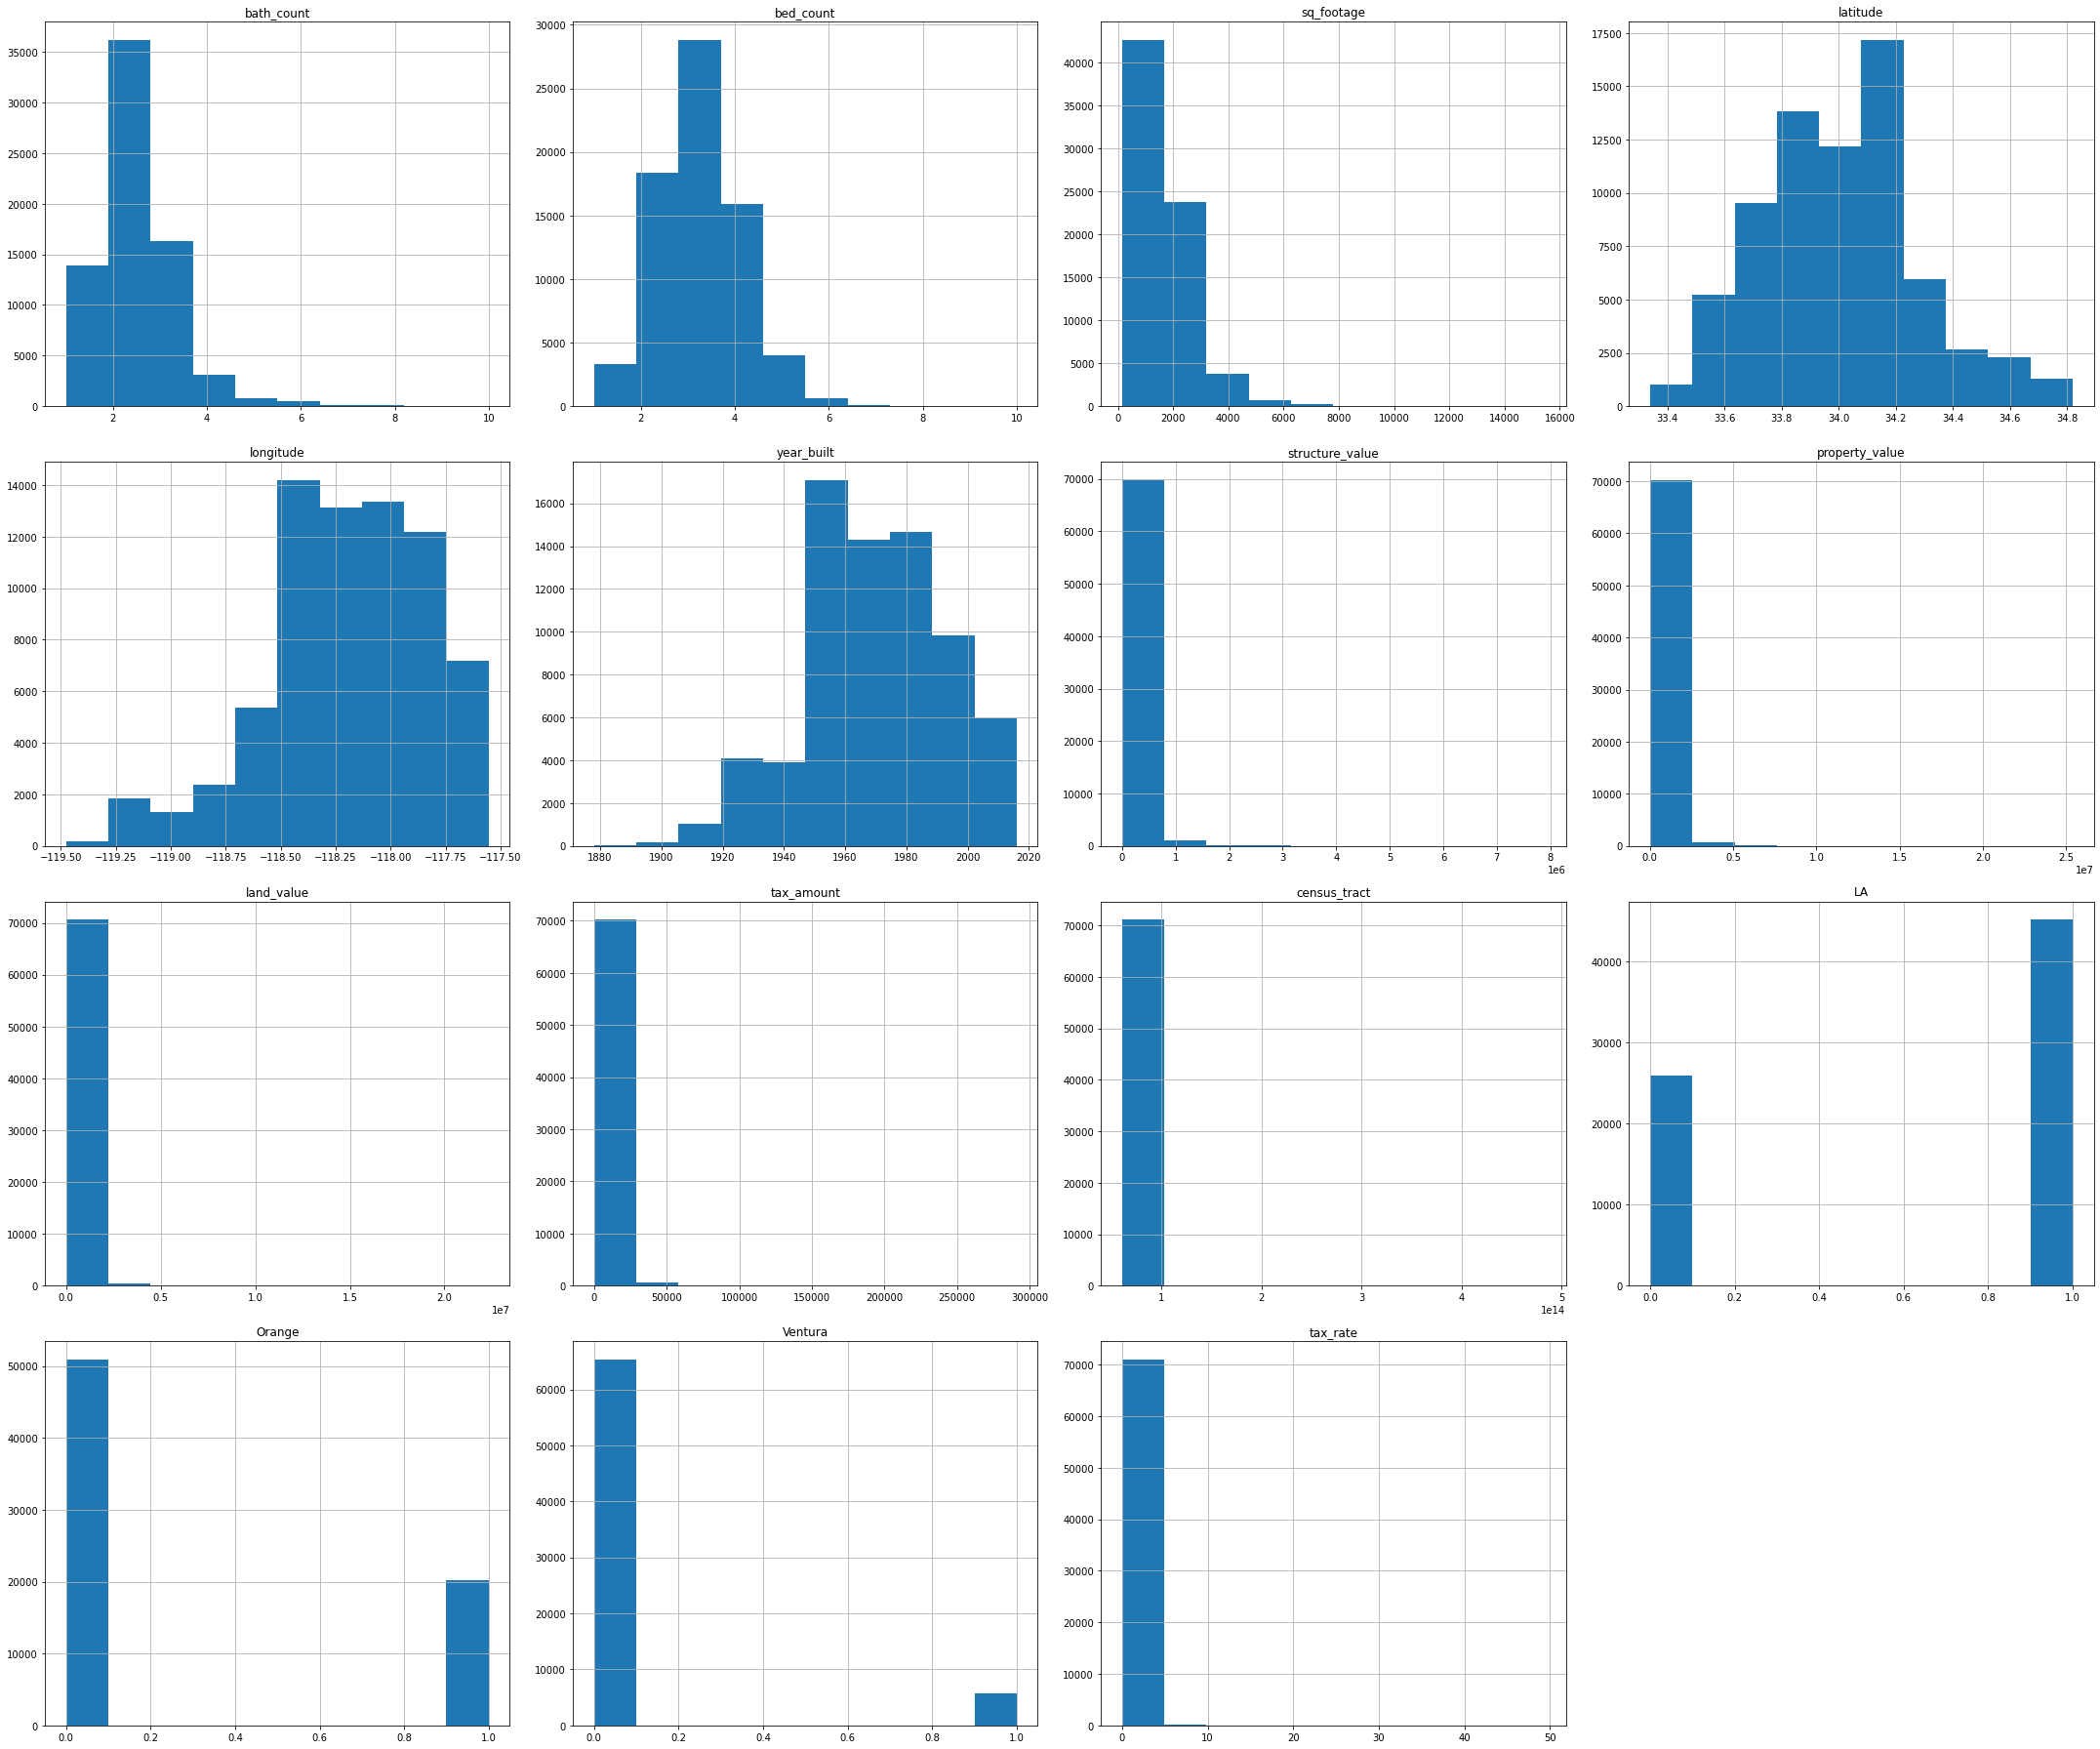

In [21]:
# visualize distributions
zillow_df.drop(columns=['target', 'parcel_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()

In [22]:
# assign columns to remove IQR outliers from
outlier_cols = ['land_value', 'property_value',
                'structure_value', 'tax_amount', 'sq_footage']

In [23]:
def shed_iqr_outliers(df, k=1.5, col_list=None):
    '''
    Takes in a DataFrame and optional column list and removes values 
    that are outside of the uppper and lower bounds for all columns or
    those passed within the list
    '''
    
    # if col_list=['list', 'of', 'cols'], apply outlier removal to cols
    # in col_list
    if col_list != None:
        # start loop for each column in col_list
        for col in col_list:
            # find q1 and q3
            q1, q3 = df[col].quantile([.25, .75])
            # calculate IQR
            iqr = q3 - q1
            # set upper and lower bounds
            upper_bound = q3 + k * iqr
            lower_bound = q1 - k * iqr
            # return DataFrame with IQR outliers removed
            df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    # if col_list=None, apply outlier removal to all cols
    else:
        # start loop for each column in DataFrame
        for col in list(df):
            # find q1 and q3
            q1, q3 = df[col].quantile([.25, .75])
            # calculate IQR
            iqr = q3 - q1
            # set upper and lower bounds
            upper_bound = q3 + k * iqr
            lower_bound = q1 - k * iqr
            # return DataFrame with IQR outliers removed
            df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    return df


zillow_df = shed_iqr_outliers(zillow_df, col_list=outlier_cols) 

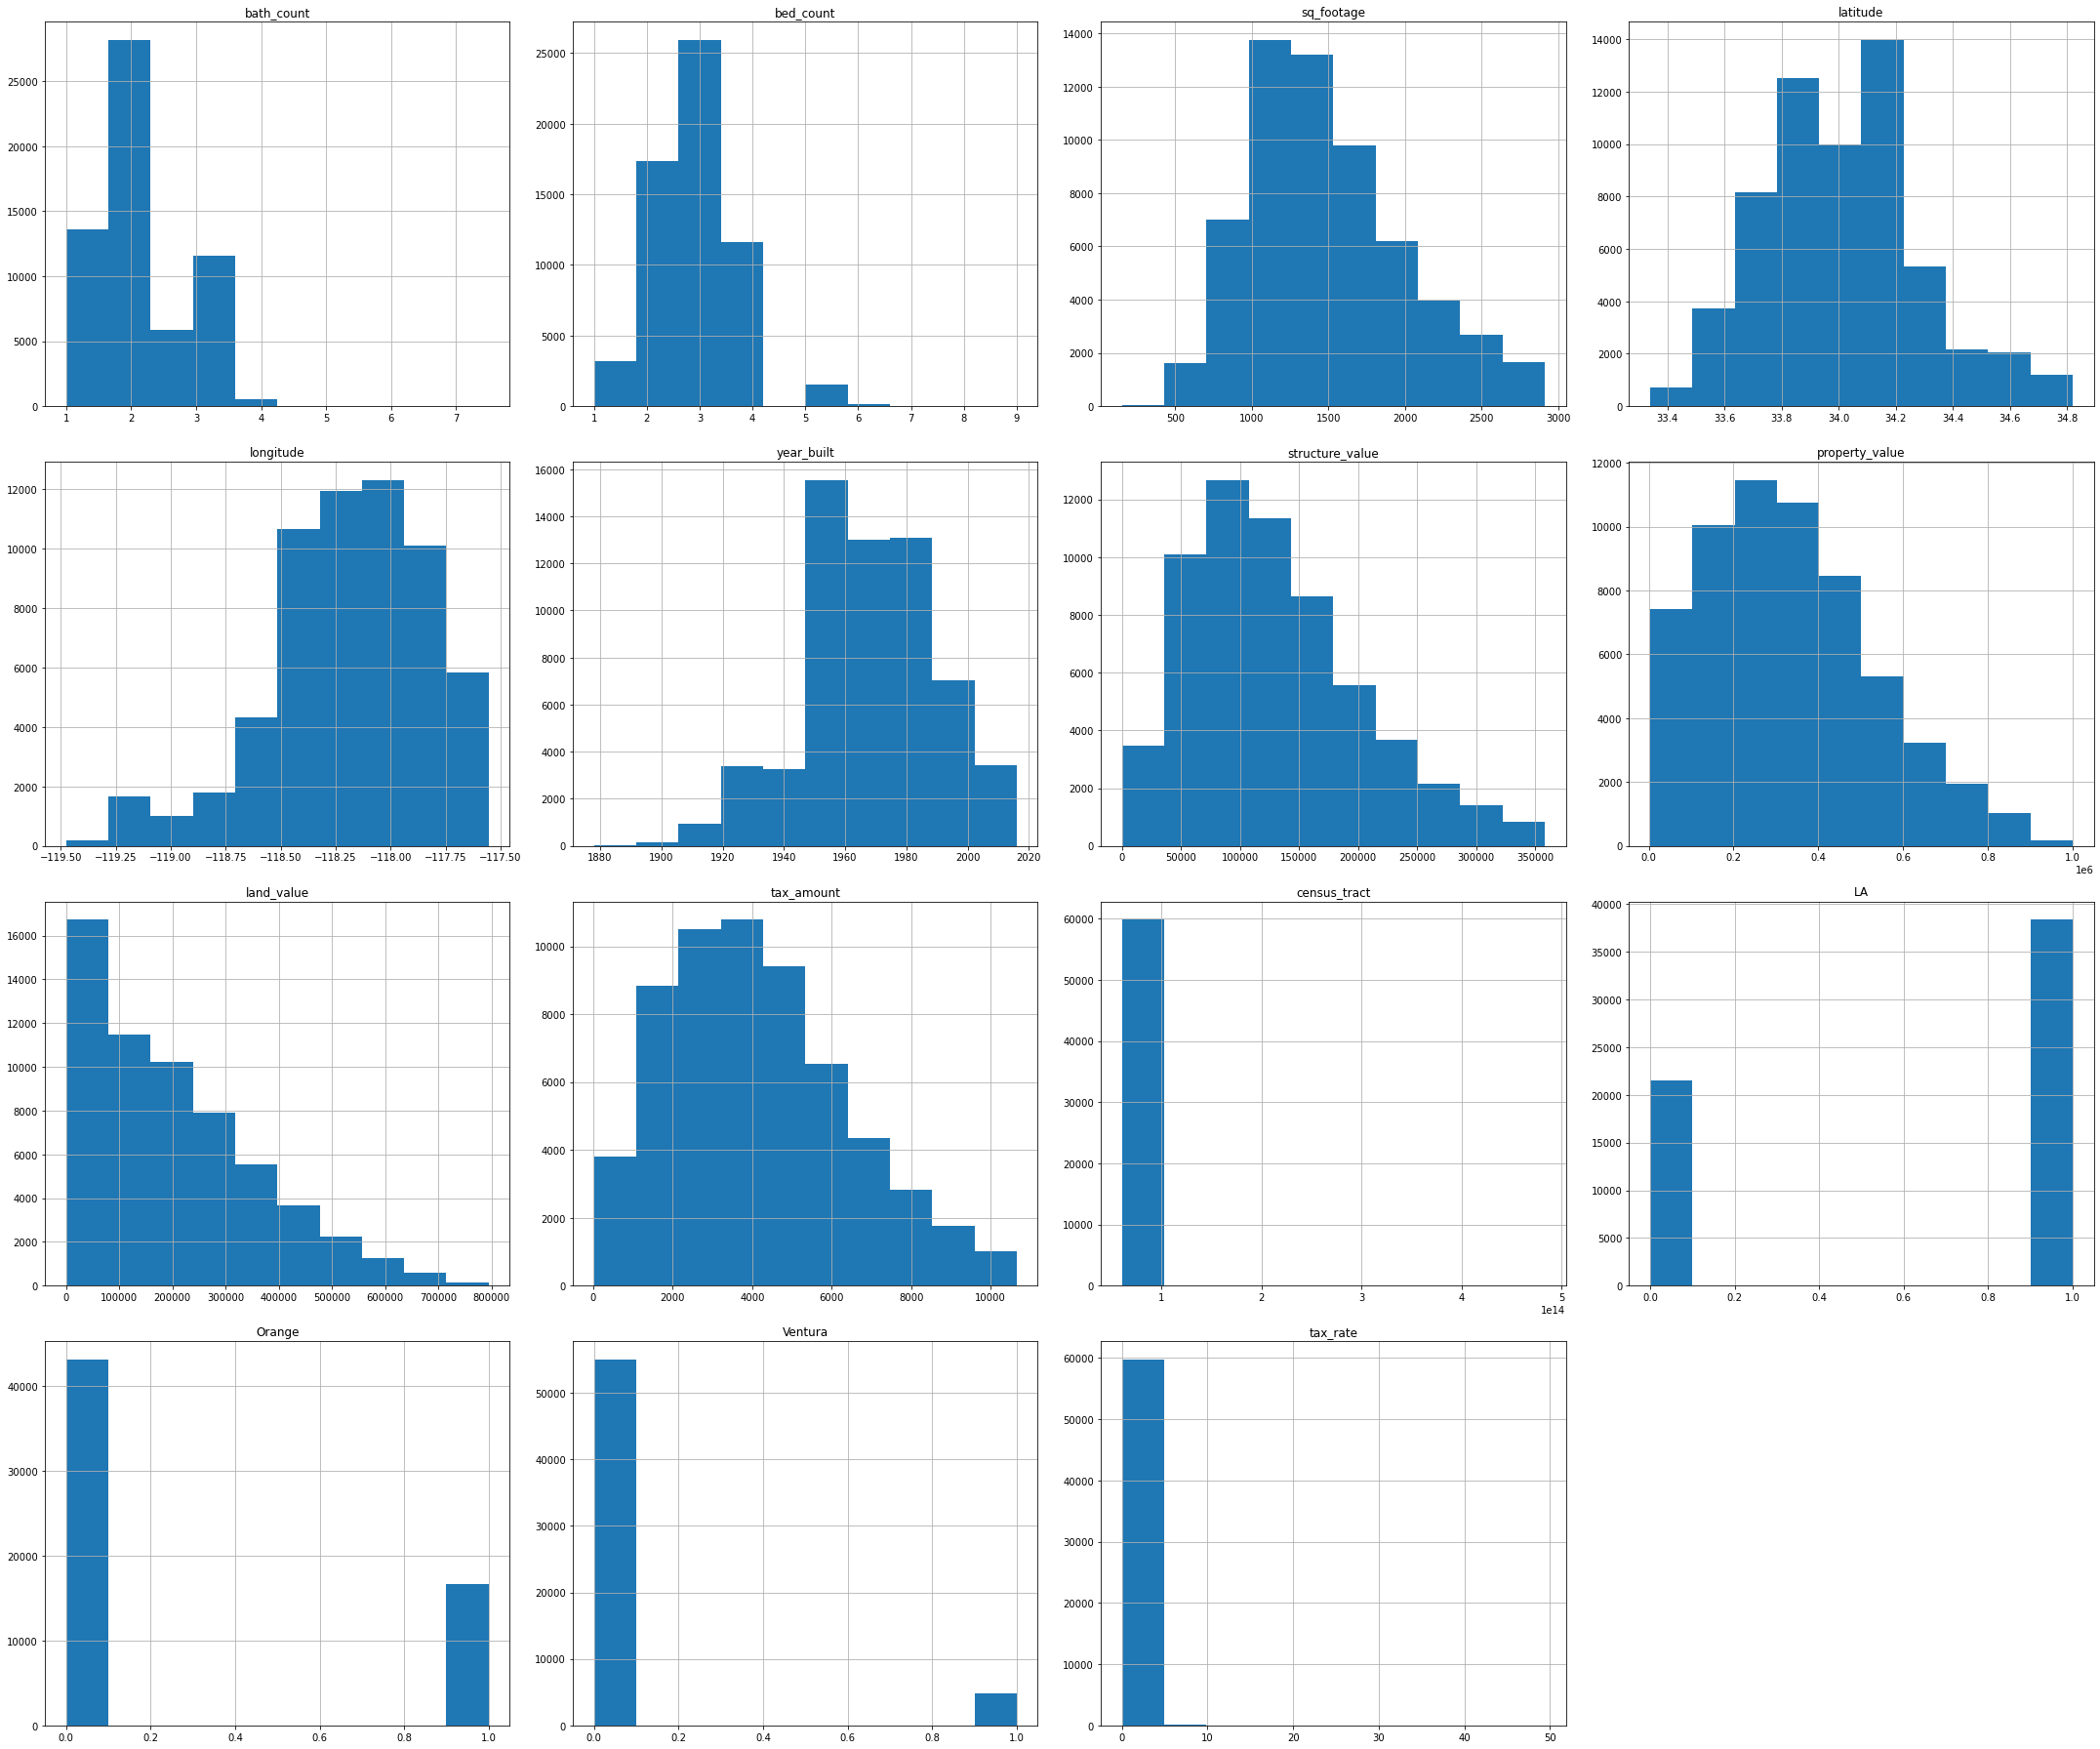

In [24]:
# visualize distributions after outlier removal
zillow_df.drop(columns=['target', 'parcel_id']).hist(figsize=(30,25))
plt.tight_layout()
plt.show()


===============================================================
# PREPARE TAKEAWAYS:
===============================================================
#Removal of the outliers improved the distributions extremely well.
#The data now looks normally distributed/expected forits associated column

In [25]:

def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples,
    a test, which is 20% of the entire dataframe,
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe.
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable.
    The function returns train, validate, test sets and also another 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test.
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = (train_test_split(df, test_size=.2, random_state=123))
   
    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [26]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(zillow_df, target='target')


In [28]:
train.shape


(33502, 17)

In [29]:
validate.shape


(14358, 17)

In [30]:
test.shape

(11966, 17)

## SCALING THE DATA

#Utilized a MinMaxScaller for the data to transform each value in the column proprtionately with the desirable range 0 and 1. 
#Additionally we are dealing with different units for values (dollar, sq ft)

In [31]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    #Fit the thing
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    
    #transform the thing
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled


scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)


In [32]:
#Made a copy of the y_train series and copied to df
y_train_scaled = pd.DataFrame(y_train)
# # combine target to DataFrame for exploration
train_scaled_comp = pd.concat((X_train_scaled, y_train_scaled), axis=1)



#=============================================================================
# Initial thoughts and Hypothesis
#=============================================================================

 There seems to be a logical correlation to property location with the gleaning that has been done so far. However, a statistical test will help settle whether any correlation is the result of chance. Below you will find the null and alternate hypothesizes for the variables explored.
 
 A statistical test will be performed and then compared against an established significance level.
 
 H0: There is no linear correlation between the variables explored and log error.

 Ha: There is a linear correlation between the variables explored and log error.
 alpha = 0.05


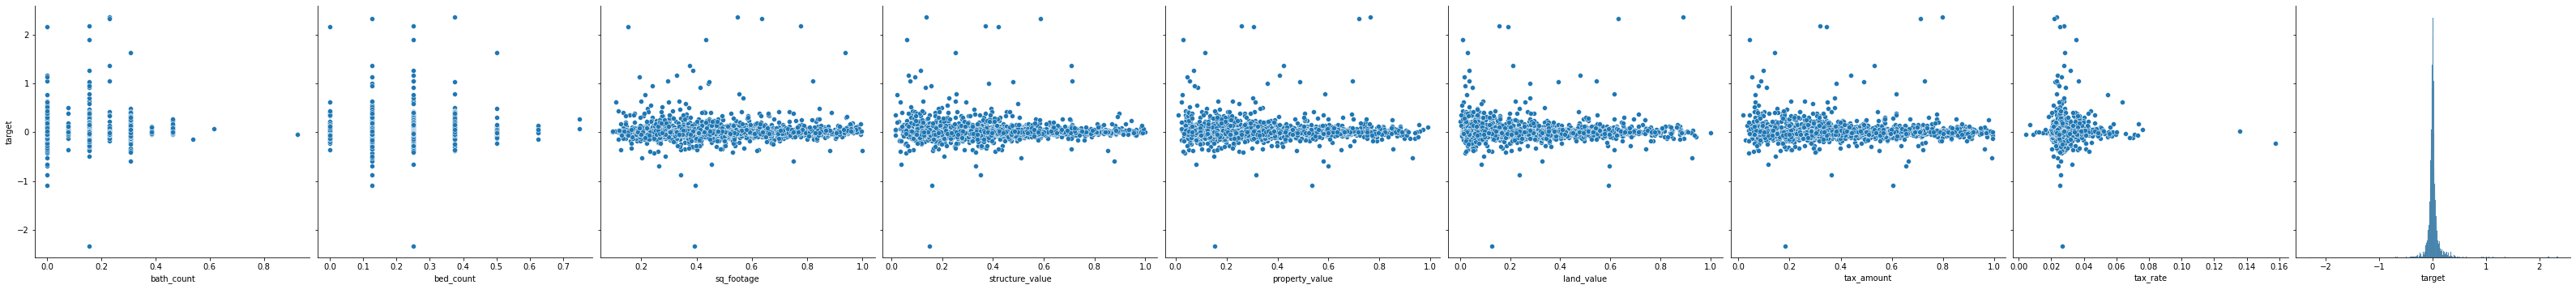

In [33]:
# create a pairplot for quick glance at variable interaction
sns.pairplot(train_scaled_comp.drop(
    columns=['census_tract', 'LA', 'Ventura', 'Orange', 'latitude', 'longitude',
             'parcel_id', 'year_built'])\
             .sample(n=3000, random_state=19), y_vars=['target'], height=5, aspect=1)


In [34]:
# create heatmap to find any obvious correlations to target

def target_heat(df, target, method='pearson'):
    '''
    Use seaborn to create heatmap with coeffecient annotations to
    visualize correlation between all variables
    '''

    # define variable for corr matrix
    heat_churn = df.corr()[target][:-1]
    # set figure size
    fig, ax = plt.subplots(figsize=(30, 1))
    # define cmap for chosen color palette
    cmap = sns.diverging_palette(h_neg=220, h_pos=13, sep=25, as_cmap=True)
    # plot matrix turned to DataFrame
    sns.heatmap(heat_churn.to_frame().T, cmap=cmap, center=0,
                annot=True, fmt=".1g", cbar=False, square=True)
    #  improve readability of xticks, remove churn ytick
    plt.xticks(ha='right', va='top', rotation=35, rotation_mode='anchor')
    plt.yticks(ticks=[])
    # set title and print graphic
    plt.title(f'Correlation to {target}\n')
    plt.show()

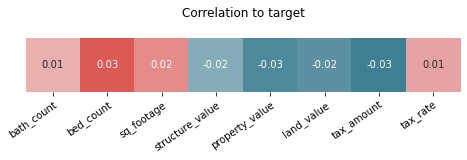

In [35]:
target_heat(train_scaled_comp.drop(
    columns=['census_tract', 'LA', 'Ventura', 'Orange', 'latitude', 'longitude',
             'parcel_id', 'year_built']), 'target')

## Hypothesis Testing Correlation to Target

In [36]:

def corr_test(data, x, y, alpha=0.05, r_type='pearson'):
    '''
    Performs a pearson or spearman correlation test and returns the r
    measurement as well as comparing the return p valued to the pass or
    default significance level, outputs whether to reject or fail to
    reject the null hypothesis
    
    '''
    
    # obtain r, p values
    if r_type == 'pearson':
        r, p = pearsonr(data[x], data[y])
    if r_type == 'spearman':
        r, p = spearmanr(data[x], data[y])
    # print reject/fail statement
    print(f'''{r_type:>10} r = {r:.2g}
+--------------------+''')
    if p < alpha:
        print(f'''
        Due to p-value {p:.2g} being less than our significance level of \
{alpha}, we may reject the null hypothesis 
        that there is not a linear correlation between "{x}" and "{y}."
        ''')
    else:
        print(f'''
        Due to p-value {p:.2g} being greater than our significance level of \
{alpha}, we fail to reject the null hypothesis 
        that there is not a linear correlation between "{x}" and "{y}."
        ''')


In [38]:
# perform statistical tests on strongest correlations according to heatmap
corr_test(train_scaled_comp, 'bed_count', 'target')
corr_test(train_scaled_comp, 'sq_footage', 'target')
corr_test(train_scaled_comp, 'bath_count', 'target')
corr_test(train_scaled_comp, 'land_value', 'target')

   pearson r = 0.025
+--------------------+

        Due to p-value 4e-06 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "bed_count" and "target."
        
   pearson r = 0.017
+--------------------+

        Due to p-value 0.0014 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "sq_footage" and "target."
        
   pearson r = 0.012
+--------------------+

        Due to p-value 0.023 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "bath_count" and "target."
        
   pearson r = -0.025
+--------------------+

        Due to p-value 6.3e-06 being less than our significance level of 0.05, we may reject the null hypothesis 
        that there is not a linear correlation between "land_value" and "target."
        


In [39]:
def plot_univariate(data, variable):
    '''
    This function takes the passed DataFrame the requested and plots a
    configured boxenplot and distrubtion for it side-by-side
    '''

    # set figure dimensions
    plt.figure(figsize=(30,8))
    # start subplot 1 for boxenplot
    plt.subplot(1, 2, 1)
    sns.boxenplot(x=variable, data=data)
    plt.axvline(data[variable].median(), color='pink')
    plt.axvline(data[variable].mean(), color='red')
    plt.xlabel('')
    plt.title('Enchanced Box Plot', fontsize=25)
    # start subplot 2 for displot
    plt.subplot(1, 2, 2)
    sns.histplot(data=data, x=variable, element='step', kde=True, color='cyan',
                                line_kws={'linestyle':'dashdot', 'alpha':1})
    plt.axvline(data[variable].median(), color='pink')
    plt.axvline(data[variable].mean(), color='red')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Distribution', fontsize=20)
    # set layout and show plot
    plt.suptitle(f'{variable} $[n = {data[variable].count():,}]$', fontsize=25)
    plt.tight_layout()
    plt.show()


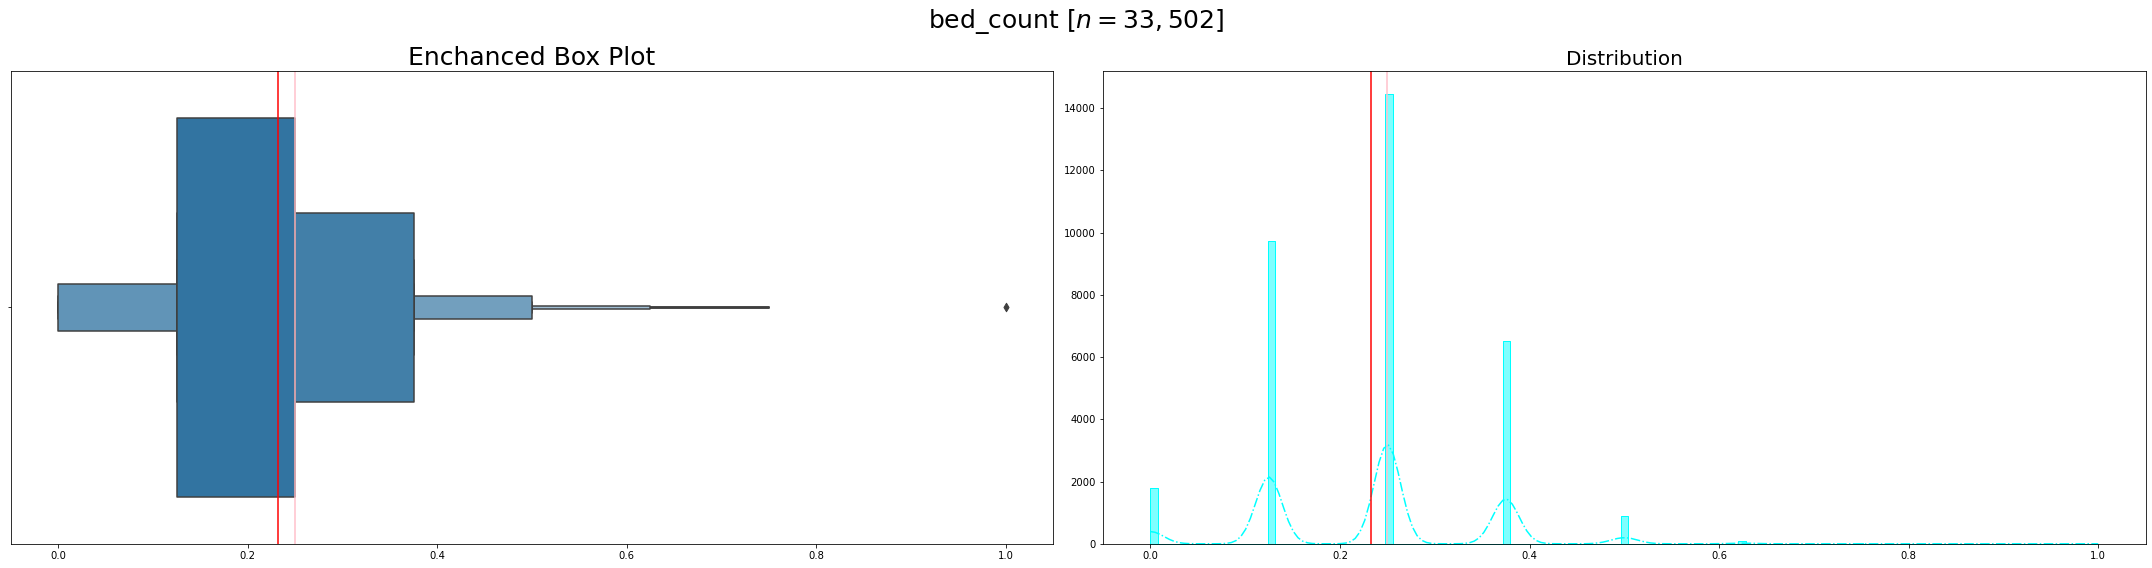

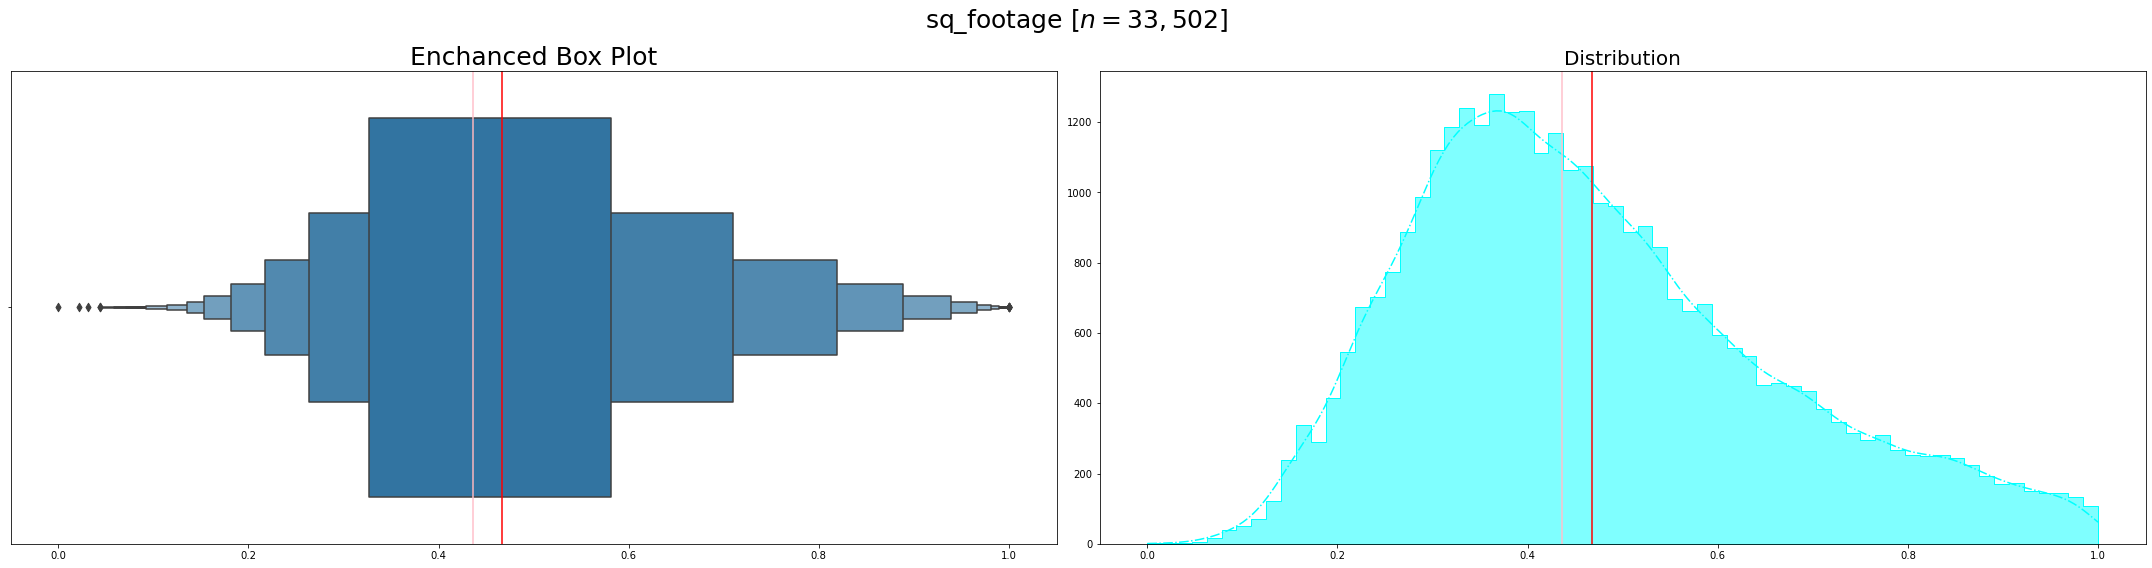

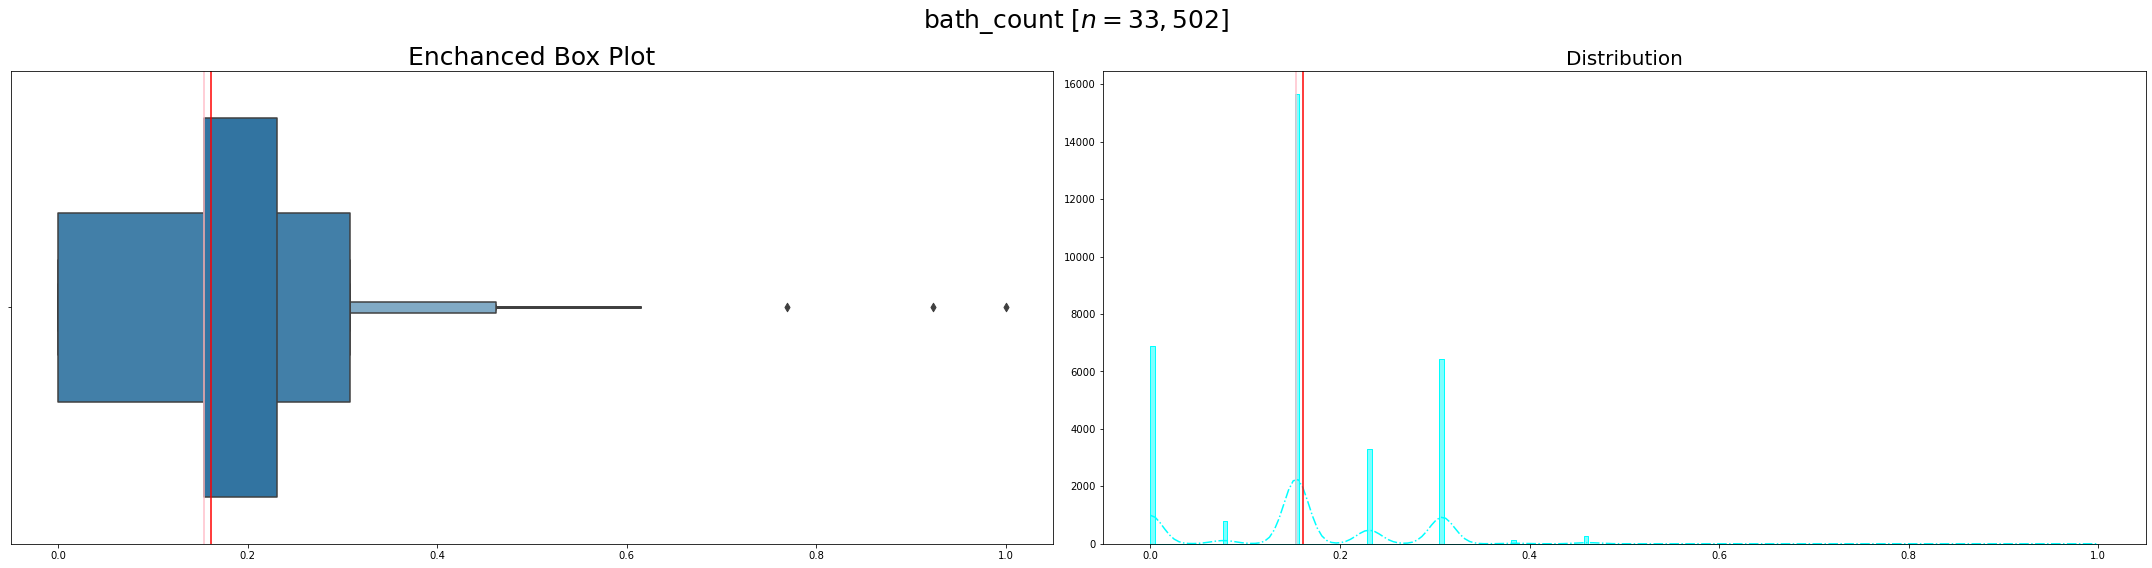

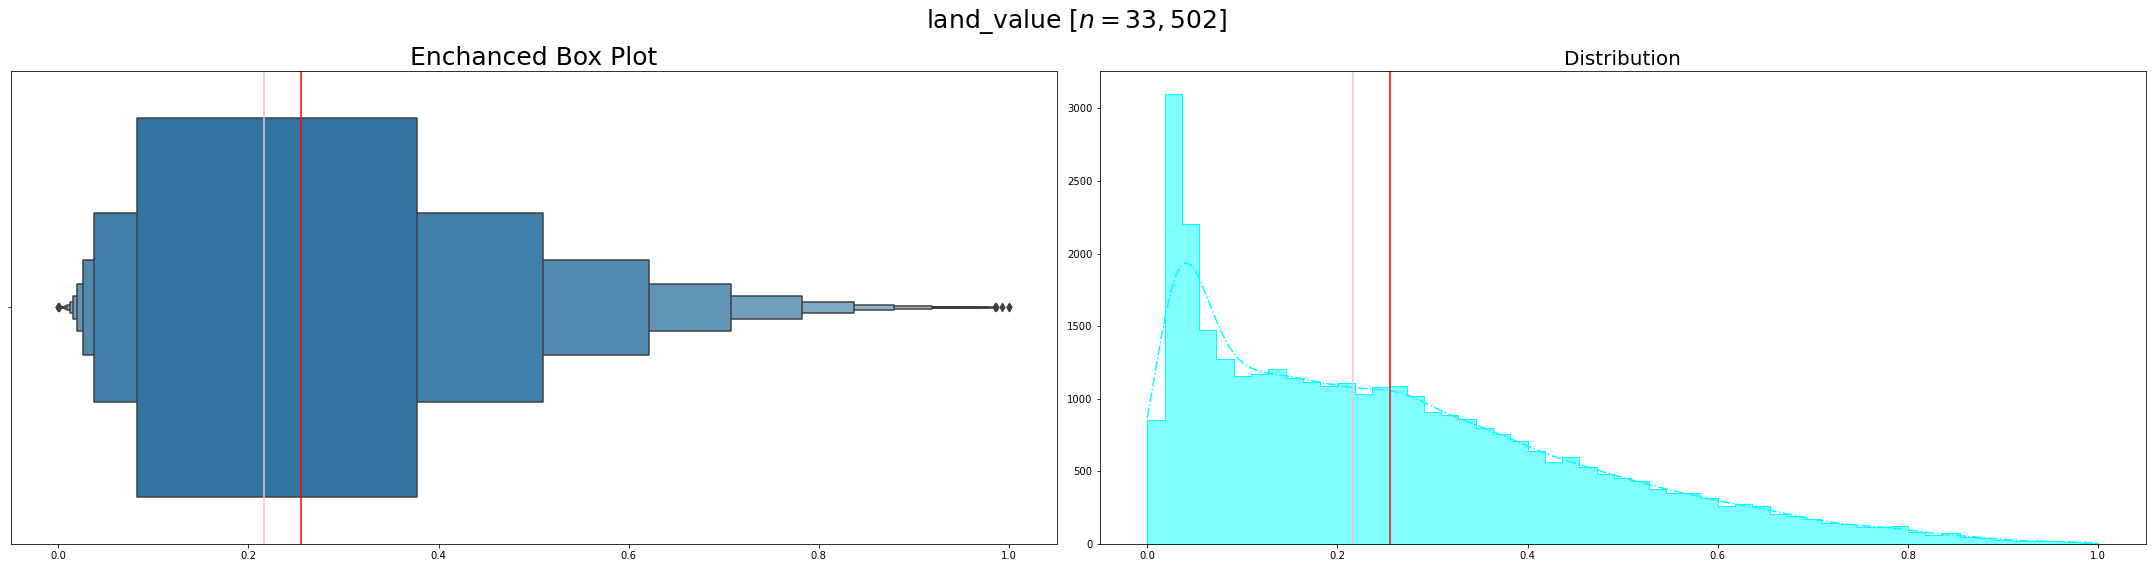

In [40]:
# look more closely at strongest correlations to log_error
plot_univariate(train_scaled_comp, 'bed_count')
plot_univariate(train_scaled_comp, 'sq_footage')
plot_univariate(train_scaled_comp, 'bath_count')
plot_univariate(train_scaled_comp, 'land_value')

## THOUGHTS/OBSERVATIONS/TAKEAWAYS

In [ ]:
# By observing the plot of variables to the target log_error, there is no clear relationship
#  made evident with the individual variables. Looking at the pair plot, all of the variables
#  show a significant range in logerror individually. There is no strong correlation between
#  the target, log error, and the other variables. There is an apparent significantly strong
#  negative correlation between bath_count and land_value with the target. This may be due
#  to a unique interaction of the variables that are having an effect on log_error. Clustering
#  will aid in methods of exploration to define any possible relationships evident between the
#  target and variables presented.

## Cluster Exploration

In [ ]:
# With the use of my initial hypothesis that were previously stated, methods of clustering
#  are utilized to establish any meaningful insight into possible key drivers of the target
#  log_error.
# 
# Iterations will be performed in variable exploration in order to identify clusters that
#  not only identify drivers of the target but perhaps even support future modeling
#  predictions. 
# 
# An analysis of variance test (ANOVA) will aid in cluster comparison. The elbow plot
#  method will be utilized for clustering where k is the point of least change to
#  inertia.

In [41]:
def elbow_plot(df, col_list):
    '''
    Takes in a DataFrame and column list to use below method to find
    changes in inertia for increasing k in cluster creation methodology
    '''

    # set figure parameters
    plt.figure(figsize=(30, 15))
    # create series and apply increasing k values to test for inertia
    pd.Series({k: KMeans(k).fit(df[col_list])\
                            .inertia_ for k in range(2, 15)}).plot(marker='*')
    # define plot labels and visual components
    plt.xticks(range(2, 15))
    plt.xlabel('$k$')
    plt.ylabel('Inertia')
    plt.ylim(0,50000)
    plt.title('Changes in Inertia for Increasing $k$')
    plt.show()
    

In [42]:
# set col_list for cluster formation
col_list_scaled = ['latitude', 'longitude']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



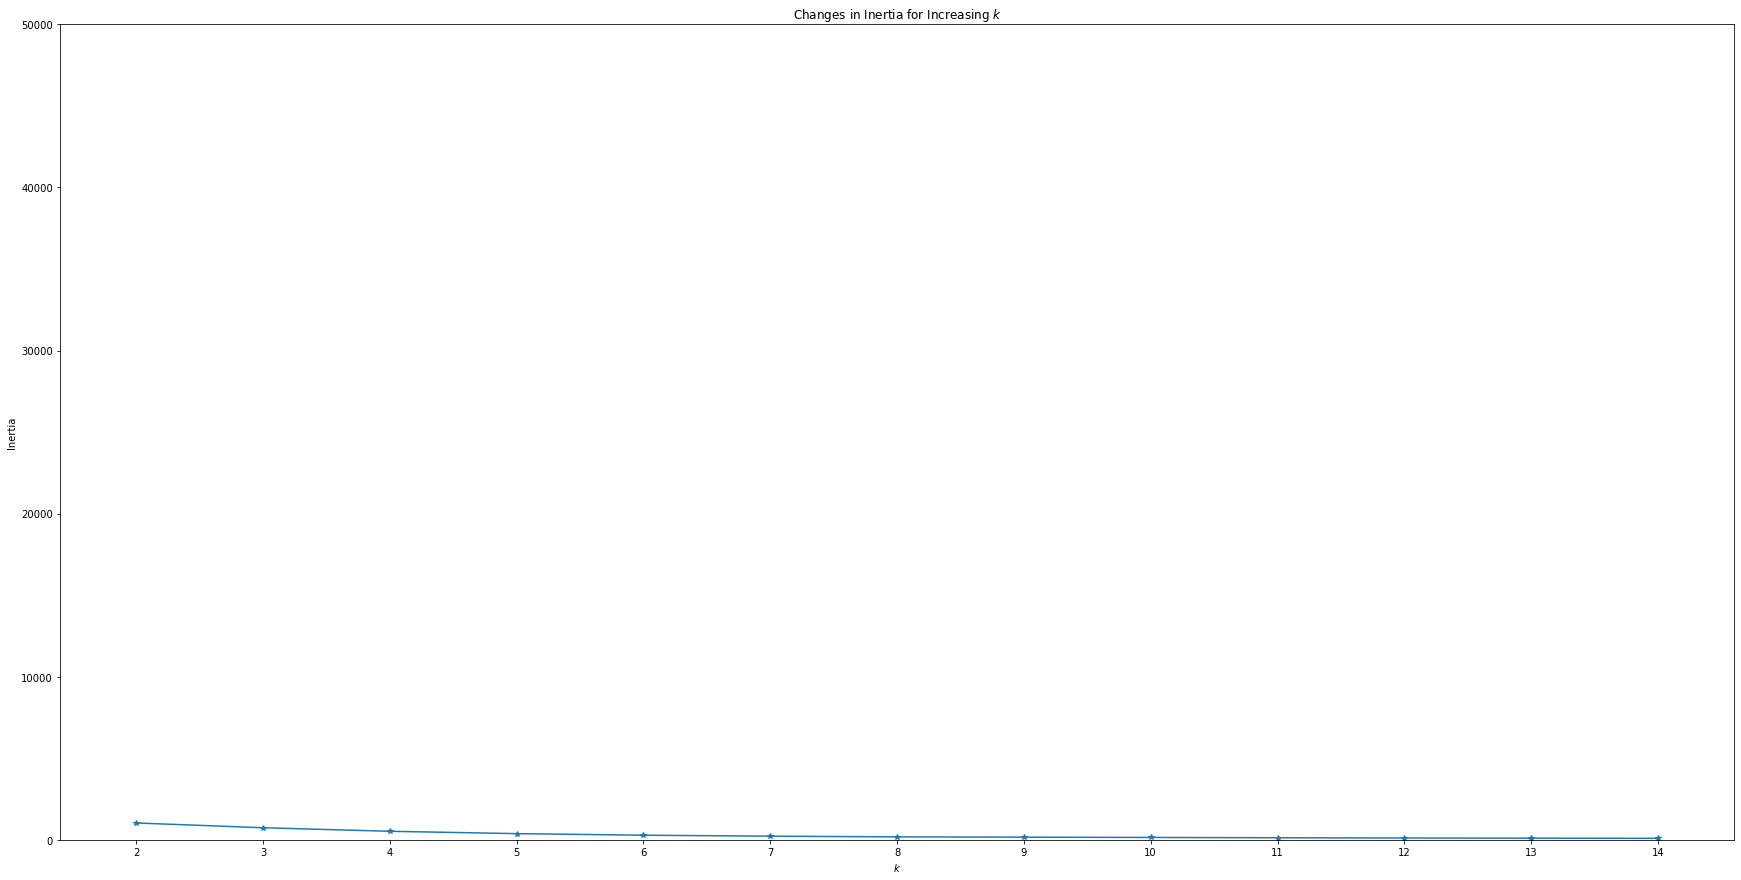

In [43]:
# create plot to use elbow method to find best k
elbow_plot(explore_df, col_list_scaled)

In [44]:
def explore_clusters(df, col_list, k=2):
    '''
    Takes in a DataFrame, column list, and optional integer value for
    k to create clusters for the purpose of exploration, returns a
    DataFrame containing cluster group numbers and cluster centers
    '''

    # create kmeans object
    kmeans = KMeans(n_clusters=k, random_state=19)
    # fit kmeans
    kmeans.fit(df[col_list])
    # store predictions
    cluster_df = pd.DataFrame(kmeans.predict(df[col_list]), index=df.index,
                                                        columns=['cluster'])
    cluster_df = pd.concat((df[col_list], cluster_df), axis=1)
    # store centers
    center_df = cluster_df.groupby('cluster')[col_list].mean()
    
    return cluster_df, center_df, kmeans

In [45]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore_clusters(explore_df, col_list_scaled, k=5)


In [46]:

def plot_clusters(cluster_df, center_df, x_var, y_var):
    '''
    Takes in cluster and centers DataFrame created by explore_clusters
    function and plots the passed x and y variables that make up that
    cluster group with different colors
    '''

    # define cluster_ column for better seaborn interpretation
    cluster_df['cluster_'] = 'cluster_' + cluster_df.cluster.astype(str)
    # set scatterplot and dimensions
    plt.figure(figsize=(28, 14))
    sns.scatterplot(x=x_var, y=y_var, data=cluster_df, hue='cluster_', s=100)
    # plot cluster centers
    center_df.plot.scatter(x=x_var, y=y_var, ax=plt.gca(), s=300, c='k',
                                        edgecolor='w', marker='$\\bar{x}$')
    # set labels and legend, show
    plt.xlabel(f'\n{x_var}\n', fontsize=20)
    plt.ylabel(f'\n{y_var}\n', fontsize=20)
    plt.title('\nClusters and Their Centers\n', fontsize=30)
    plt.legend(bbox_to_anchor=(0.95,0.95), fontsize=20)

    plt.show()

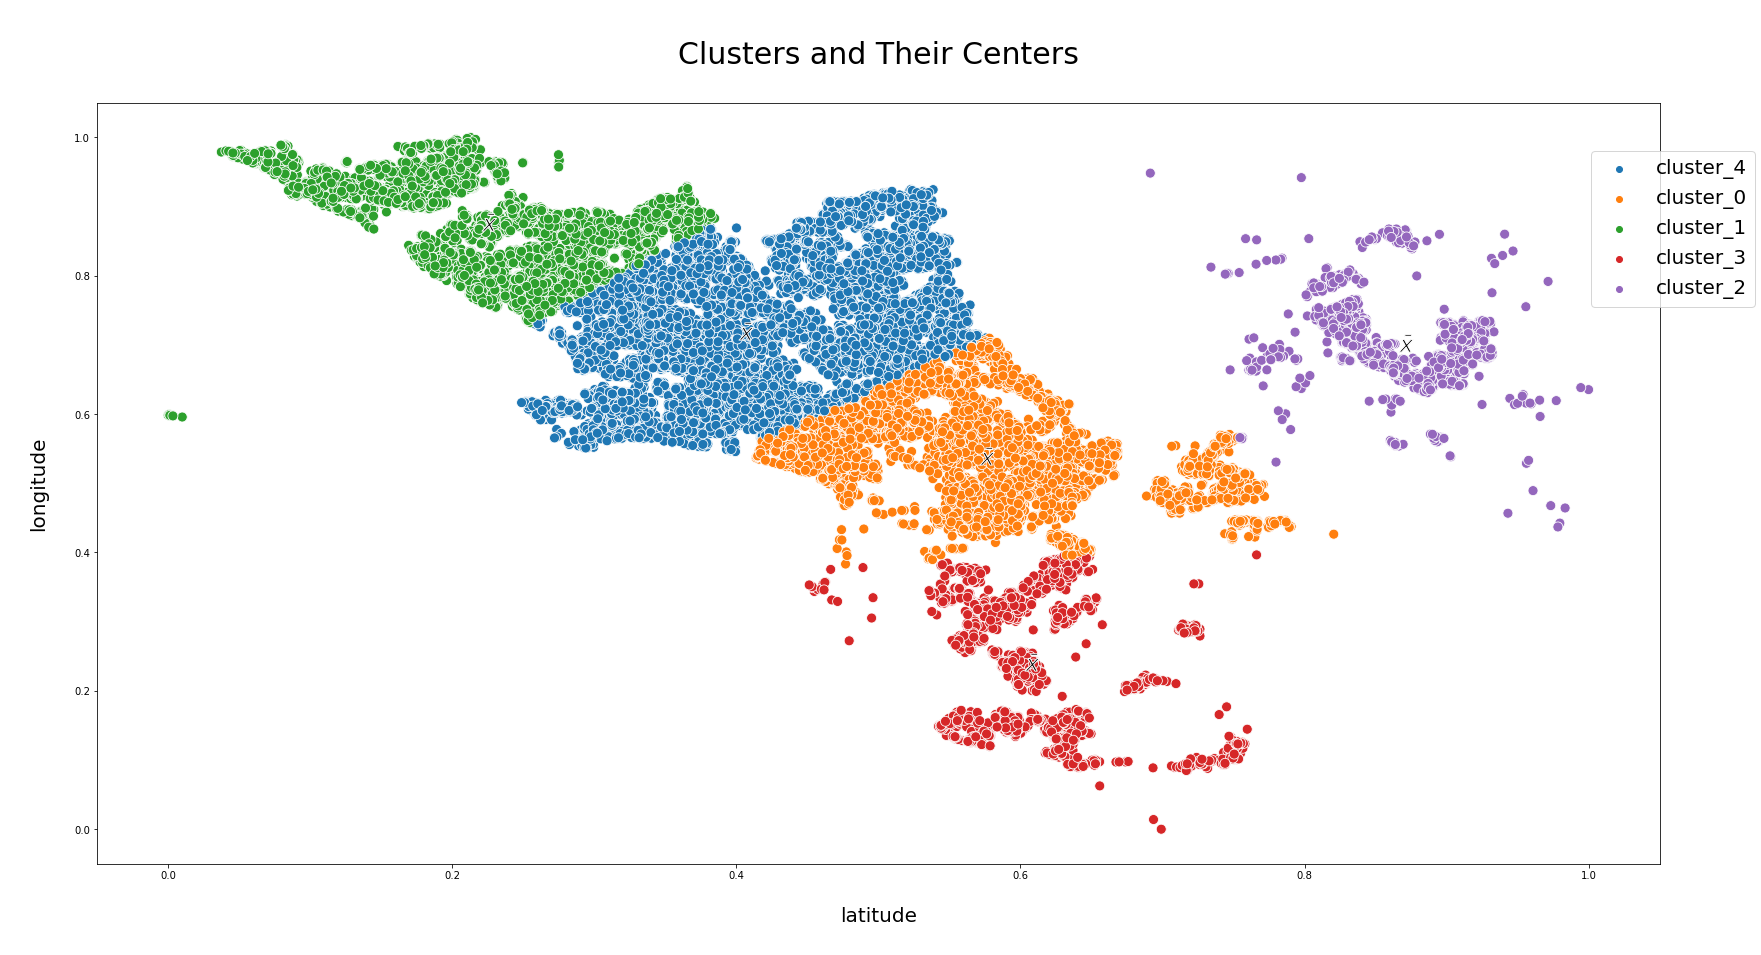

In [47]:
# create plot to view clusters for lat_long_clstr
plot_clusters(cluster_df, center_df, 'latitude', 'longitude')

In [48]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 2.20 |  𐄂 Fail to reject
| p-value: 0.07 |  the null hypothesis.
+---------------+



In [ ]:
# Striking out with the initial hypothesis, below the relationship of count of
#  bedrooms and squarefootage will be clustered and explored
#  against the target. The clusters will then be compared using an ANOVA test.

In [49]:
# set col_list for cluster formation
col_list_scaled = ['bed_count', 'sq_footage']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



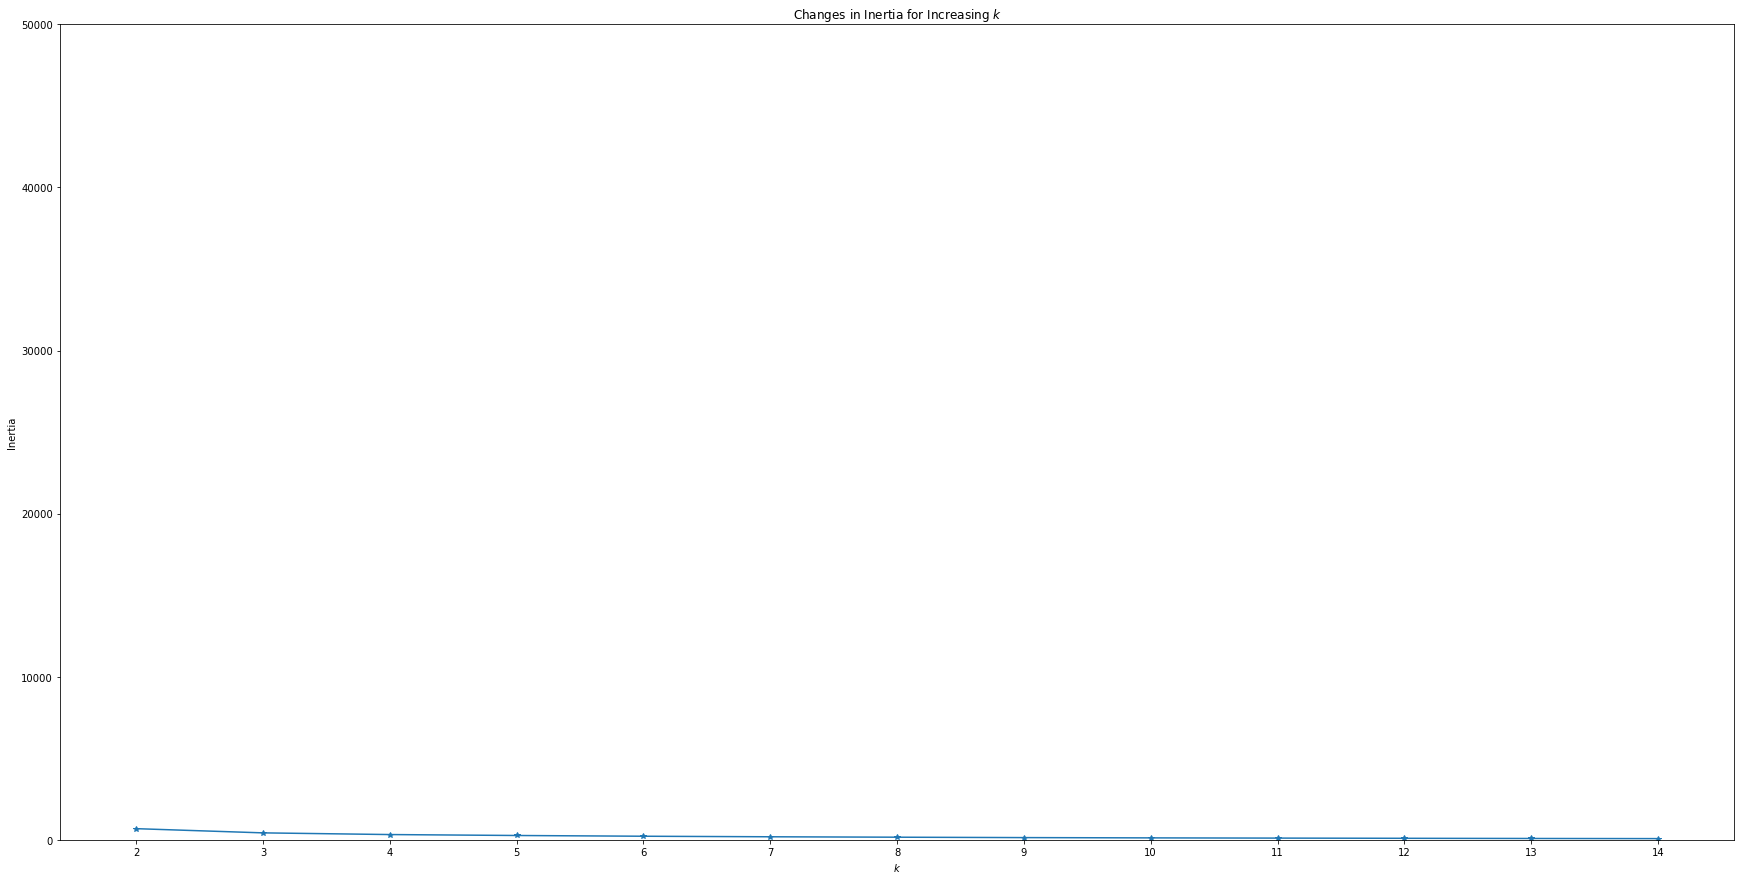

In [50]:
# create plot to use elbow method to find best k
elbow_plot(explore_df, col_list_scaled)

In [51]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore_clusters(explore_df, col_list_scaled, k=5)


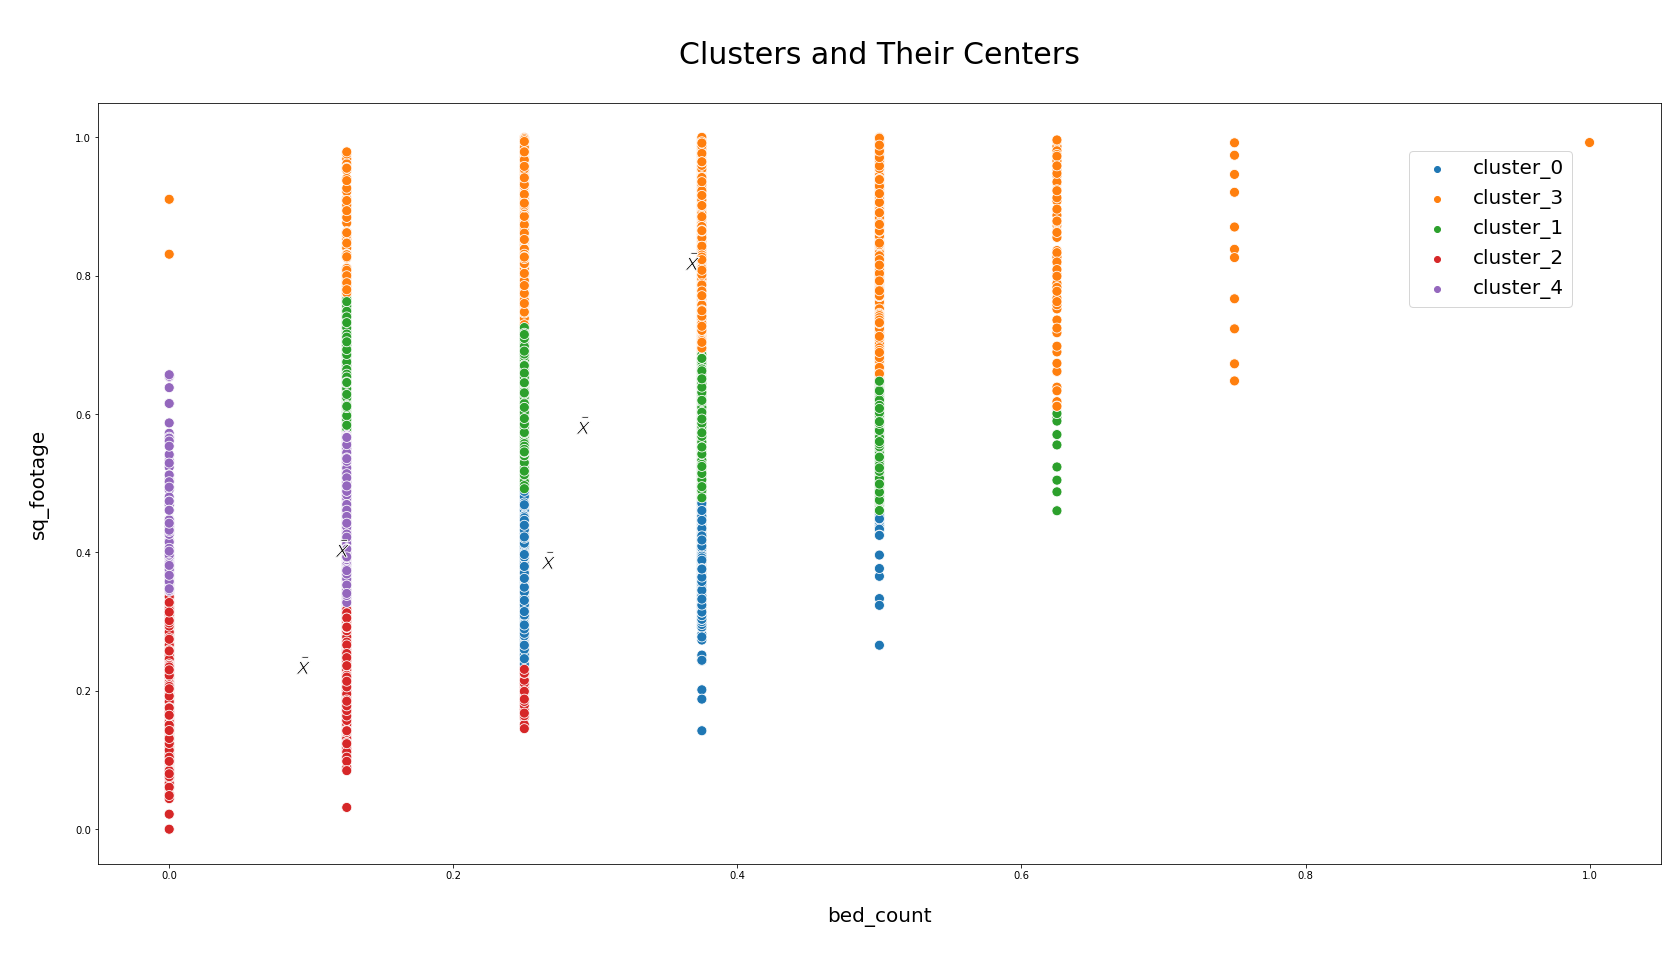

In [52]:
# create plot to view clusters for lat_long_clstr
plot_clusters(cluster_df, center_df, 'bed_count', 'sq_footage')



In [53]:

# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')



      Stats
+---------------+
| F-value: 6.06 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



In [122]:

# add cluster to DataFrame for feature exploration
train_scaled_comp['bed_sq_foot_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['bed_sq_foot_clstr'], drop_first=True)



## Latitude/ Longitude/ Property Value

In [123]:
# set col_list for cluster formation
col_list_scaled = ['latitude', 'longitude', 'property_value']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]

In [124]:
# create plot to use elbow method to find best k
elbow_plot(explore_df, col_list_scaled)

NameError: name 'f' is not defined

In [56]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore_clusters(explore_df, col_list_scaled, k=5)

In [57]:

def plot_three_d_clusters(cluster_df, center_df, x_var, y_var, z_var):
    '''
    Takes in cluster and centers DataFrame created by explore_clusters
    function and creates a three dimesnional plot of the passed x, y,
    and z variables that make up that cluster group with different
    colors
    '''

    # set figure and axes
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')    
    # set clusters for each cluster passed in arguments
    # set x, y, z for cluster 0
    x0 = cluster_df[cluster_df['cluster'] == 0][x_var]
    y0 = cluster_df[cluster_df['cluster'] == 0][y_var]
    z0 = cluster_df[cluster_df['cluster'] == 0][z_var]
    # set x, y, z for cluster 1
    x1 = cluster_df[cluster_df['cluster'] == 1][x_var]
    y1 = cluster_df[cluster_df['cluster'] == 1][y_var]
    z1 = cluster_df[cluster_df['cluster'] == 1][z_var]
    # set x, y, z for each additional cluster
    if len(center_df) > 2:
        x2 = cluster_df[cluster_df['cluster'] == 2][x_var]
        y2 = cluster_df[cluster_df['cluster'] == 2][y_var]
        z2 = cluster_df[cluster_df['cluster'] == 2][z_var]
    if len(center_df) > 3:
        x3 = cluster_df[cluster_df['cluster'] == 3][x_var]
        y3 = cluster_df[cluster_df['cluster'] == 3][y_var]
        z3 = cluster_df[cluster_df['cluster'] == 3][z_var]
    if len(center_df) > 4:
        x4 = cluster_df[cluster_df['cluster'] == 4][x_var]
        y4 = cluster_df[cluster_df['cluster'] == 4][y_var]
        z4 = cluster_df[cluster_df['cluster'] == 4][z_var]
    if len(center_df) > 5:
        x5 = cluster_df[cluster_df['cluster'] == 5][x_var]
        y5 = cluster_df[cluster_df['cluster'] == 5][y_var]
        z5 = cluster_df[cluster_df['cluster'] == 5][z_var]
        
    # set centers for each cluster passed in arguments
    # set centers for clusters 0, 1
    zero_center = center_df[center_df.index == 0]
    one_center = center_df[center_df.index == 1]
    # set centers for each additional clusters
    if len(center_df) > 2:
        two_center = center_df[center_df.index == 2]
    if len(center_df) > 3:
        three_center = center_df[center_df.index == 3]
    if len(center_df) > 4:
        four_center = center_df[center_df.index == 4]
    if len(center_df) > 5:
        five_center = center_df[center_df.index == 5]
    if len(center_df) > 6:
        six_center = center_df[center_df.index == 6]
        
    # plot clusters and their centers for each cluster passed in arguments
    # plot cluster 0 with center
    ax.scatter(x0, y0, z0, s=100, c='c', edgecolor='k', marker='o',
                                                    label='Cluster 0')
    ax.scatter(zero_center[x_var], zero_center[y_var], zero_center[z_var],
                                    s=300, c='c', marker='$\\bar{x}$')
    # plot cluster 1 with center
    ax.scatter(x1, y1, z1, s=100, c='y', edgecolor='k', marker='o',
                                                    label='Cluster 1')
    ax.scatter(one_center[x_var], one_center[y_var], one_center[z_var],
                                    s=300, c='y', marker='$\\bar{x}$')
    # plot each additional cluster passed in arguments
    if len(center_df) > 2:
        ax.scatter(x2, y2, z2, s=100, c='m', edgecolor='k', marker='o',
                                                    label='Cluster 2')
        ax.scatter(two_center[x_var], two_center[y_var], two_center[z_var],
                                    s=300, c='m', marker='$\\bar{x}$')
    if len(center_df) > 3:
        ax.scatter(x3, y3, z3, s=100, c='k', edgecolor='w', marker='o',
                                                    label='Cluster 3')
        ax.scatter(three_center[x_var],three_center[y_var],three_center[z_var],
                                    s=300, c='k', marker='$\\bar{x}$')
    if len(center_df) > 4:
        ax.scatter(x4, y4, z4, s=100, c='r', edgecolor='k', marker='o',
                                                    label='Cluster 4')
        ax.scatter(four_center[x_var], four_center[y_var], four_center[z_var],
                                    s=300, c='r', marker='$\\bar{x}$')
    if len(center_df) > 5:
        ax.scatter(x5, y5, z5, s=100, c='g', edgecolor='k', marker='o',
                                                    label='Cluster 5')
        ax.scatter(five_center[x_var], five_center[y_var], five_center[z_var],
                                    s=300, c='g', marker='$\\bar{x}$')
    # if len(center_df) > 6:
    #     ax.scatter(x6, y6, z6, s=100, c='b', edgecolor='k', marker='o',
    #                                                 label='Cluster 6')
        ax.scatter(six_center[x_var], six_center[y_var], six_center[z_var],
                                    s=300, c='b', marker='$\\bar{x}$')
        
    # set labels, title, and legend
    ax.set_xlabel(f'\n$x =$ {x_var}', fontsize=15)
    ax.set_ylabel(f'\n$y =$ {y_var}', fontsize=15)
    ax.set_zlabel(f'\n$z =$ {z_var}', fontsize=15)
    plt.title('Clusters and Their Centers', fontsize=30)
    plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)

    plt.show()

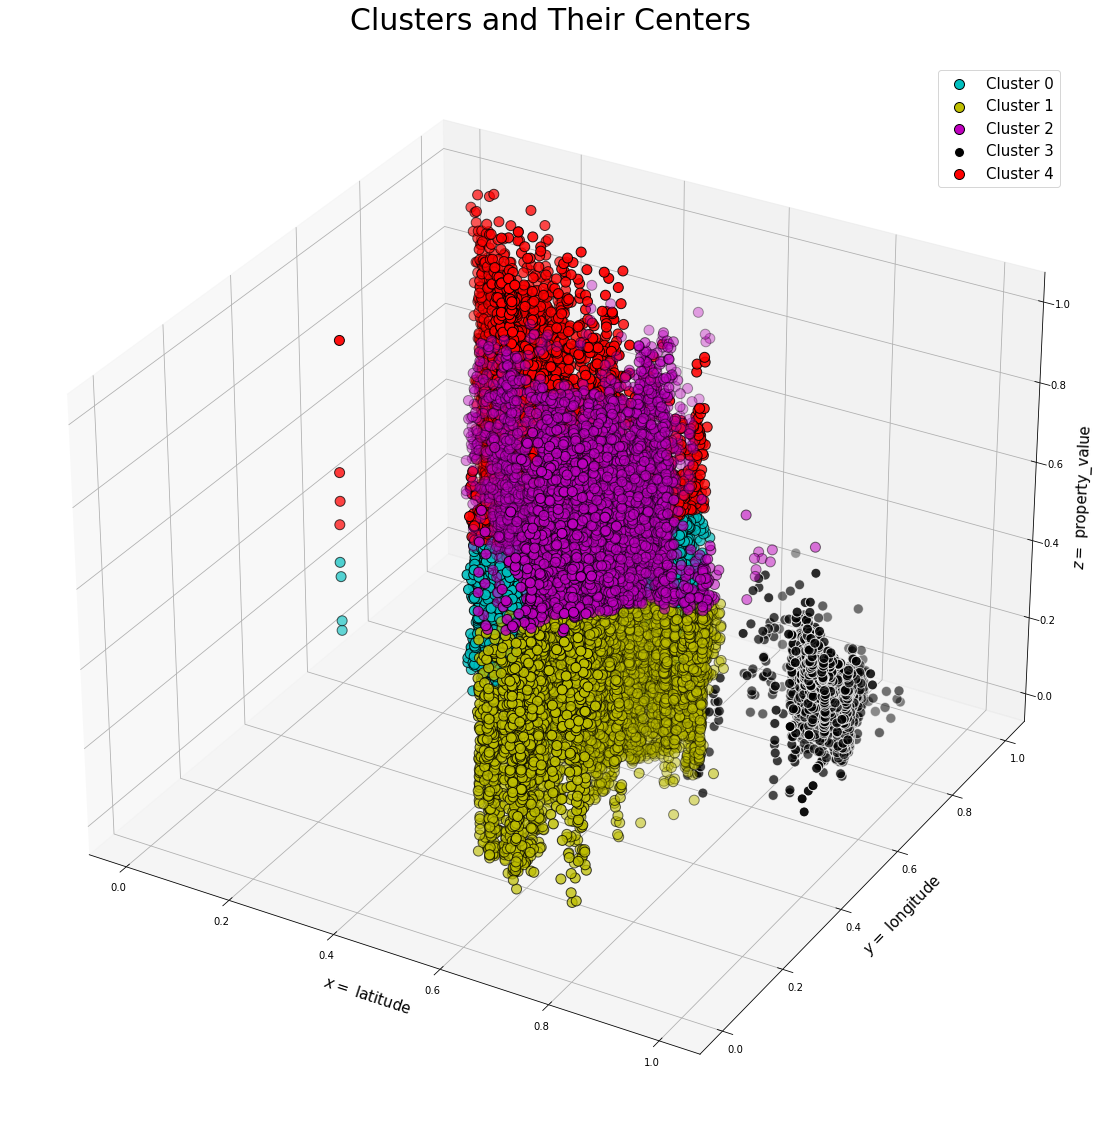

In [58]:
# create plot to view clusters for lat_long_clstr
plot_three_d_clusters(cluster_df, center_df, 'latitude', 'longitude', 'property_value')



In [59]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 8.74 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



In [152]:
# add cluster to DataFrame for feature exploration
train_scaled_comp['lat_long_pv_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['lat_long_pv_clstr'], drop_first=True)
train_scaled_comp
X1_cols = train_scaled_comp['lat_long_pv_clstr']

,parcel_id,bath_count,bed_count,sq_footage,latitude,longitude,year_built,structure_value,property_value,land_value,...,land_val_census_clstr_3,land_val_census_clstr_4,bed_sq_foot_clstr_1,bed_sq_foot_clstr_2,bed_sq_foot_clstr_3,bed_sq_foot_clstr_4,lat_long_pv_clstr_1,lat_long_pv_clstr_2,lat_long_pv_clstr_3,lat_long_pv_clstr_4
32518,0.011654,0.000000,0.250,0.335581,0.342827,0.705002,0.521739,0.328002,0.272096,0.191583,...,0,0,0,0,0,0,0,0,0,0
44300,0.000079,0.153846,0.375,0.865918,0.588733,0.432646,0.717391,0.595377,0.357000,0.176503,...,0,0,0,0,0,0,0,0,0,0
50427,0.024477,0.307692,0.375,0.830712,0.080148,0.958193,0.746377,0.622564,0.823484,0.744576,...,0,0,1,0,0,0,1,0,0,0
32534,0.009527,0.000000,0.250,0.545693,0.583273,0.695295,0.347826,0.093339,0.045176,0.015214,...,0,0,0,1,0,0,0,1,0,0
59713,0.026410,0.230769,0.125,0.313858,0.169410,0.961924,0.855072,0.423647,0.413173,0.323916,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11097,0.009094,0.153846,0.125,0.442322,0.546997,0.683248,0.688406,0.125776,0.099390,0.068017,...,0,0,0,1,0,0,0,1,0,0
63559,0.001520,0.153846,0.125,0.340824,0.563696,0.605669,0.739130,0.278881,0.206325,0.131934,...,0,0,0,0,0,0,0,0,0,0
35545,0.007250,0.000000,0.000,0.098127,0.494275,0.676096,0.333333,0.166516,0.299497,0.298576,...,0,1,0,0,0,1,0,0,0,1
10889,0.025972,0.000000,0.000,0.164794,0.334589,0.803535,0.688406,0.167128,0.164779,0.130698,...,0,0,0,0,0,0,0,0,0,0


In [150]:
cluster_df


,land_value,census_tract,cluster,cluster_
32518,0.191583,1.111987e-05,0,cluster_0
44300,0.176503,7.881293e-07,0,cluster_0
50427,0.744576,5.191182e-04,1,cluster_1
32534,0.015214,8.495972e-06,2,cluster_2
59713,0.323916,5.188802e-04,4,cluster_4
...,...,...,...,...
11097,0.068017,8.531464e-06,2,cluster_2
63559,0.131934,4.984916e-06,0,cluster_0
35545,0.298576,2.377590e-06,4,cluster_4
10889,0.130698,5.201850e-04,0,cluster_0


# BEDCOUNT VS TAX RATE 

In [63]:
# set col_list for cluster formation
col_list_scaled = ['bed_count', 'tax_rate']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



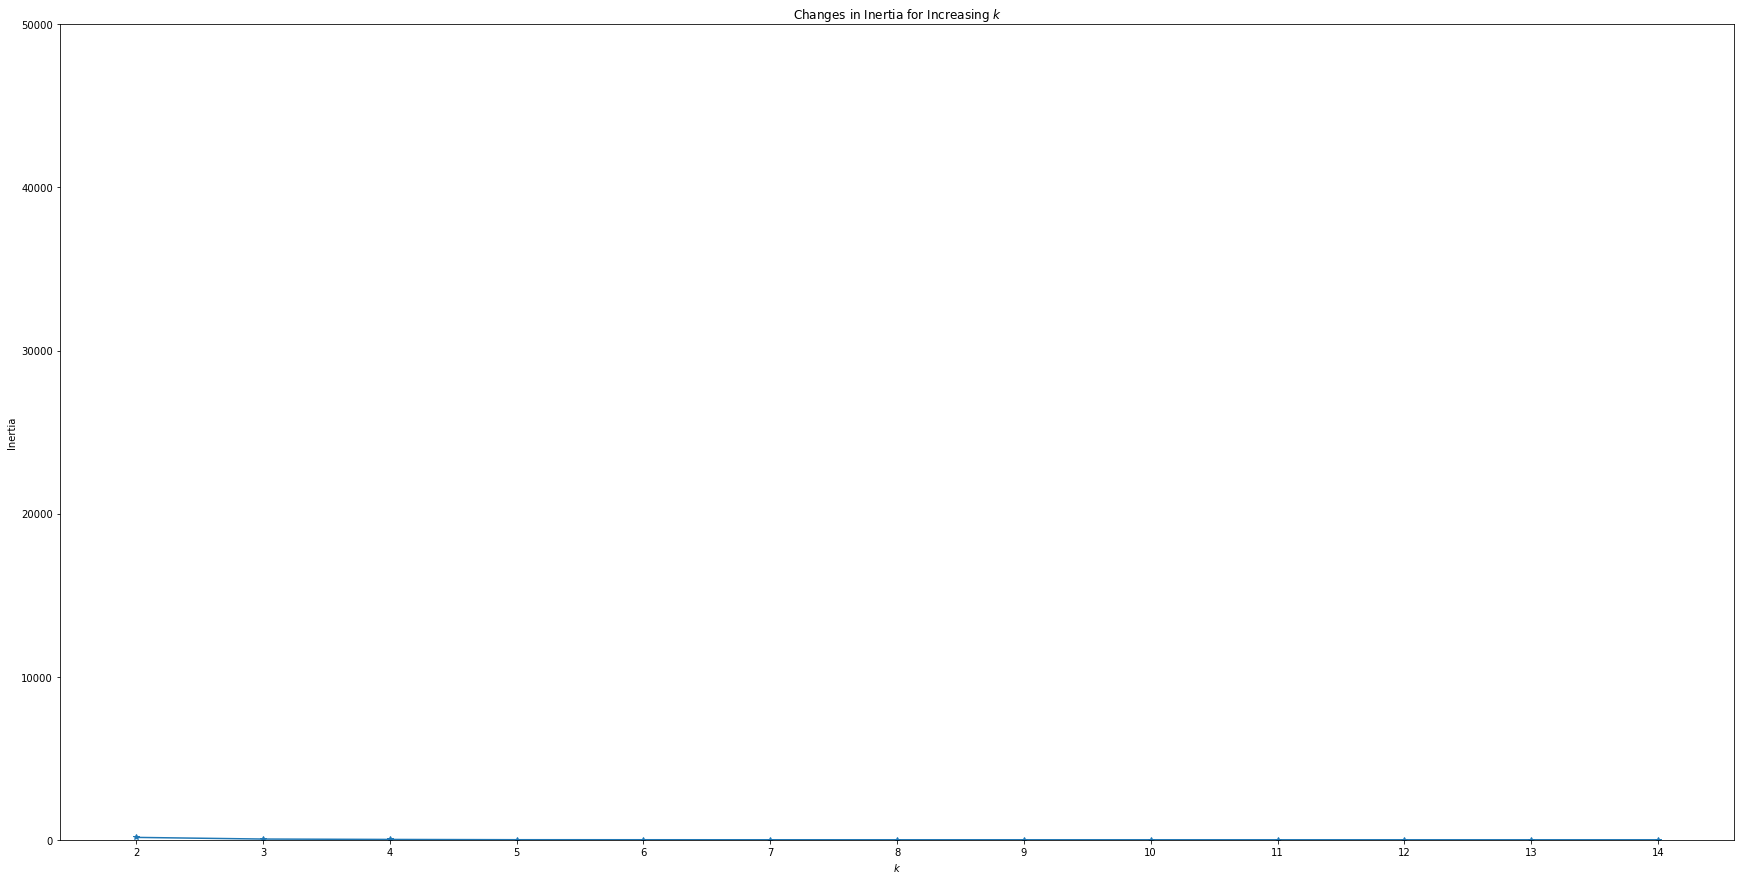

In [64]:
# create plot to use elbow method to find best k
elbow_plot(explore_df, col_list_scaled)

In [65]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore_clusters(explore_df, col_list_scaled, k=5)

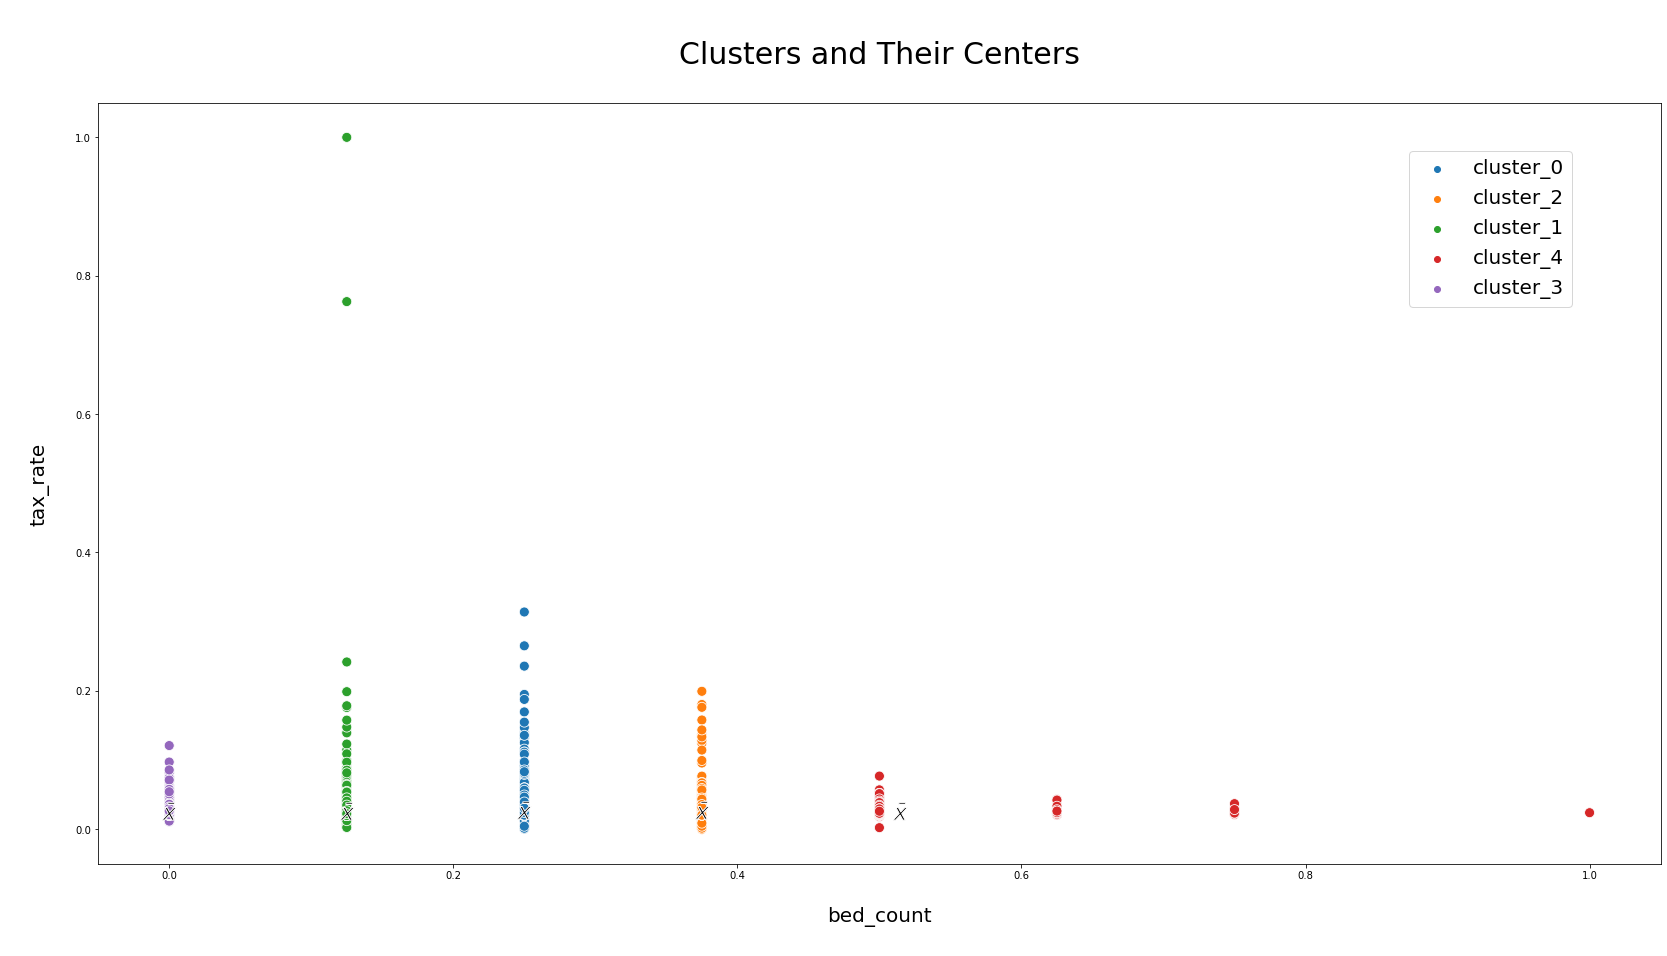

In [66]:

# create plot to view clusters for lat_long_clstr
plot_clusters(cluster_df, center_df, 'bed_count', 'tax_rate')



In [67]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 7.03 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



In [69]:
# add cluster to DataFrame for feature exploration
train_scaled_comp['bed_taxrate_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['bed_taxrate_clstr'], drop_first=True)


## Land Value Vs Census Tract

In [70]:
# set col_list for cluster formation
col_list_scaled = ['land_value', 'census_tract']
# create DataFrame for explored variables
explore_df = train_scaled_comp[col_list_scaled]



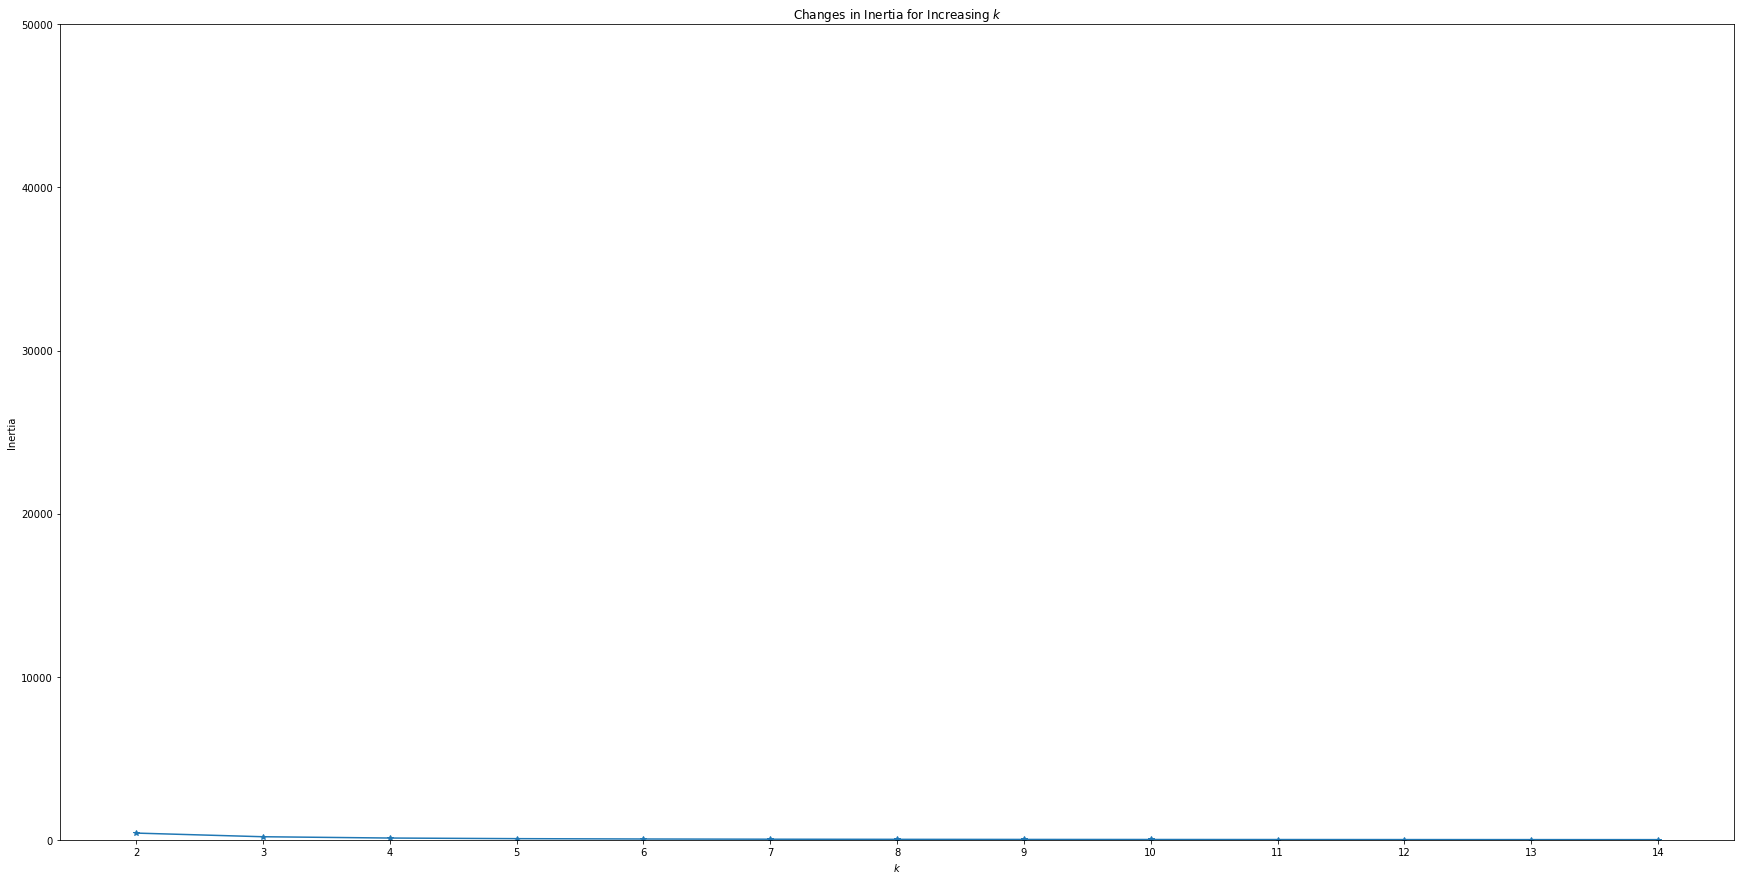

In [71]:
# create plot to use elbow method to find best k
elbow_plot(explore_df, col_list_scaled)

In [72]:
# create clusters for exploring log_error relative to location
cluster_df, center_df, kmeans = explore_clusters(explore_df, col_list_scaled, k=5)



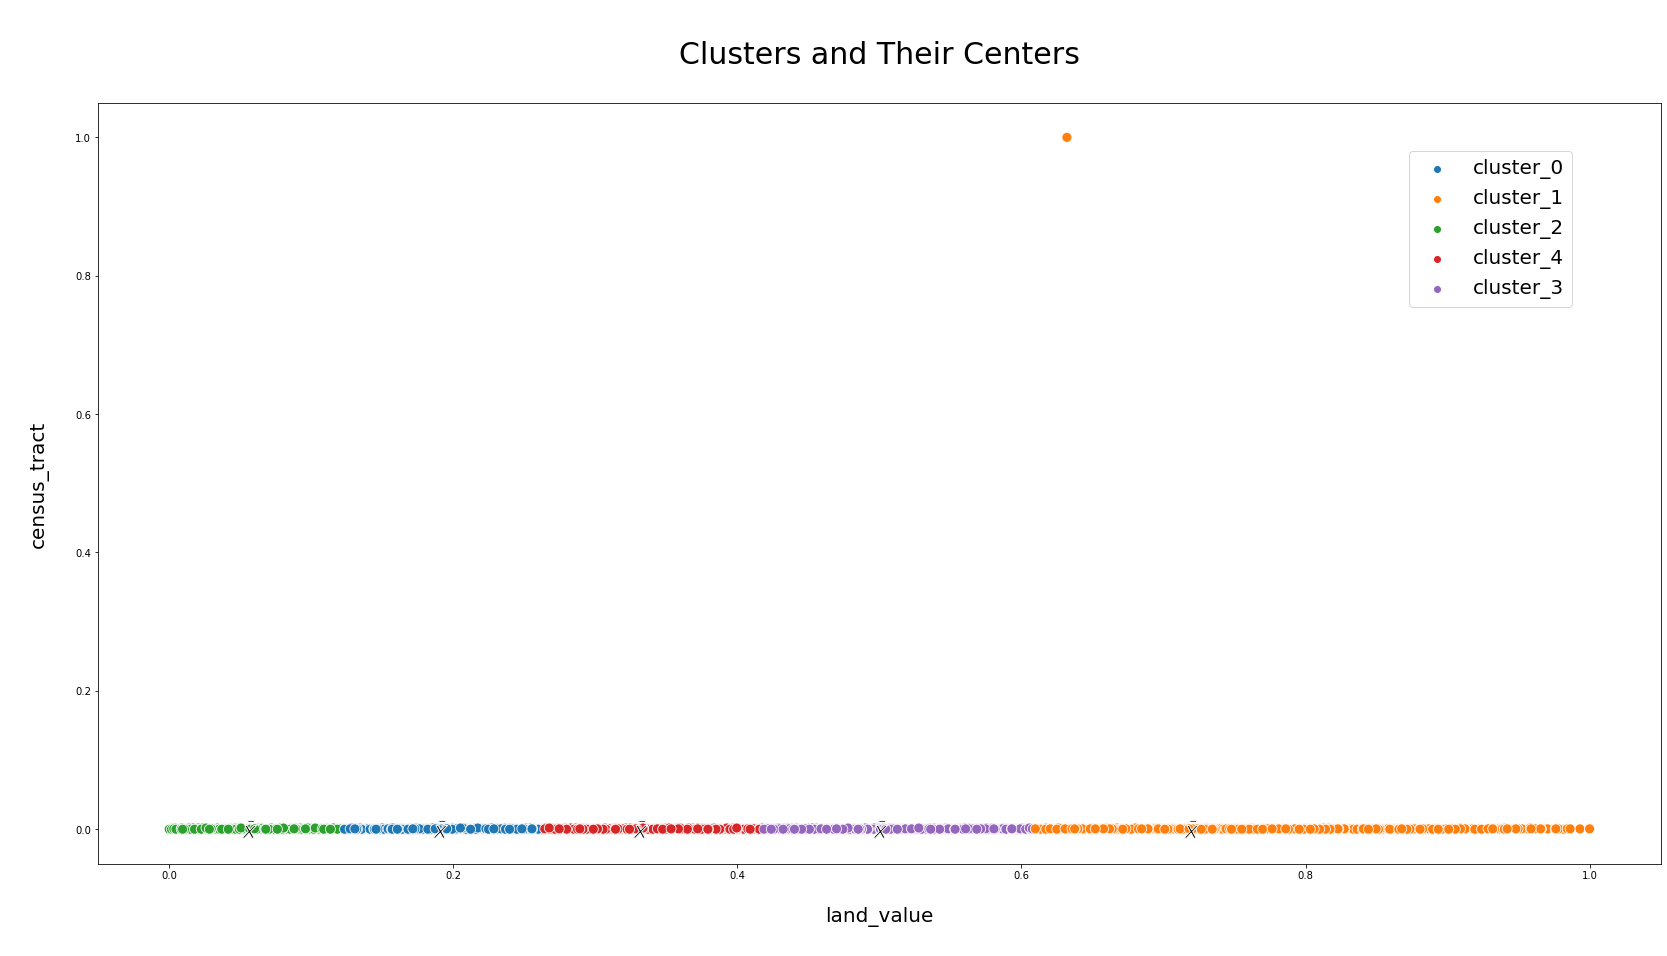

In [73]:
# create plot to view clusters for lat_long_clstr
plot_clusters(cluster_df, center_df, 'land_value', 'census_tract')



In [74]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((cluster_df, train_scaled_comp.target), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].target,
                      samples[samples.cluster == 1].target,
                      samples[samples.cluster == 2].target,
                      samples[samples.cluster == 3].target,
                      samples[samples.cluster == 4].target)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
| F-value: {F:.2f} |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
| F-value: 10.37 |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



In [75]:

# add cluster to DataFrame for feature exploration
train_scaled_comp['land_val_census_clstr'] = cluster_df.cluster
train_scaled_comp = pd.get_dummies(train_scaled_comp, columns=['land_val_census_clstr'], drop_first=True)



## CLUSTER TAKEAWAYS:

In [ ]:
#All rejected the null hypothesis except one, longitude/latitude alone

## Modeling

In [76]:
# let's find the baseline logerror...
train_scaled_comp.target.mean()

0.014964652517743034

In [79]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 

y_validate_scaled = y_validate.copy()
y_test_scaled = y_test.copy()


y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_test_scaled = pd.DataFrame(y_test_scaled)

In [80]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_test_scaled = pd.DataFrame(y_test_scaled)

In [125]:
# Predict av_pred_mean
av_pred_mean = y_train_scaled['target'].mean()
y_train_scaled['baseline'] = av_pred_mean
y_validate_scaled['baseline'] = av_pred_mean
y_test_scaled['baseline'] = av_pred_mean


In [82]:
# RMSE of av_pred_mean
rmse_train = mean_squared_error(y_train_scaled['target'], y_train_scaled['baseline']) ** 0.5
rmse_validate = mean_squared_error(y_validate_scaled['target'], y_validate_scaled['baseline']) ** 0.5


In [83]:
# How did the baseline mean perform
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

RMSE using Mean
Train/In-Sample:  0.1551 
Validate/Out-of-Sample:  0.1573


In [84]:
# Clean it up now
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate.round(4),
    'r^2_validate': explained_variance_score(y_validate_scaled['target'], y_validate_scaled['baseline'])}])
metric_df


,model,rmse_validate,r^2_validate
0,mean_baseline,0.1573,0.0


In [85]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train_scaled['target'])

# predict train
y_train_scaled['baseline'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled['target'], y_train_scaled['baseline']) ** (1/2)
# predict validate
y_validate_scaled['baseline'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled['target'], y_validate_scaled['baseline']) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.15488752156283278 
Validation/Out-of-Sample:  0.15715334472353734


In [87]:
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_scaled['target'], y_validate_scaled['baseline'])}, ignore_index=True)
metric_df


,model,rmse_validate,r^2_validate
0,mean_baseline,0.157300,0.000000
1,OLS lm 1,0.157153,0.001664


In [90]:
# use RFE to find best cluster for analysis
X = train_scaled_comp
y = train['target']

lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=4)
rfe.fit(X, y)

pd.Series(dict(zip(X.columns, rfe.ranking_))).sort_values()

target                      1
lat_long_pv_clstr_3         1
Orange                      1
LA                          1
property_value              2
Ventura                     3
structure_value             5
land_value                  6
census_tract                7
year_built                  8
parcel_id                   9
longitude                  10
tax_amount                 11
land_val_census_clstr_1    12
land_val_census_clstr_3    14
bed_sq_foot_clstr_1        15
bed_count                  16
tax_rate                   17
bed_taxrate_clstr_4        18
bath_count                 19
bed_taxrate_clstr_3        20
bed_taxrate_clstr_2        21
bed_taxrate_clstr_1        22
lat_long_pv_clstr_4        23
bed_sq_foot_clstr_2        24
latitude                   25
lat_long_pv_clstr_1        26
bed_sq_foot_clstr_4        27
bed_sq_foot_clstr_3        28
lat_long_pv_clstr_2        29
land_val_census_clstr_4    30
sq_footage                 31
land_val_census_clstr_2    32
dtype: int

In [93]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train_scaled.target)

# predict train
y_train_scaled['z_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.target, y_train_scaled.z_pred_lars)**(.5)

# predict validate
y_validate_scaled['z_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.target, y_validate_scaled.z_pred_lars)**(.5)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  0.15508870206458905 
Validation/Out-of-Sample:  0.15728403960942935


In [97]:
metric_df = metric_df.append(
    {
    'model': 'Lasso + LARS',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate_scaled['target'], y_validate_scaled['baseline'])}, ignore_index=True)
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,0.157300,0.000000
1,OLS lm 1,0.157153,0.001664
2,Lasso + LARS,0.157284,0.001664


In [98]:

# make a new column names cluster in train_scaled and X_train_scaled dataframe
train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)

X_train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)
X_validate_scaled['cluster_charlie'] = kmeans.predict(X2_validate_scaled)
X_test_scaled['cluster_charlie'] = kmeans.predict(X2_test_scaled)

Index(['parcel_id', 'bath_count', 'bed_count', 'sq_footage', 'latitude',
       'longitude', 'year_built', 'structure_value', 'property_value',
       'land_value', 'tax_amount', 'census_tract', 'LA', 'Orange', 'Ventura',
       'tax_rate', 'target', 'lat_long_pv_clstr_1', 'lat_long_pv_clstr_2',
       'lat_long_pv_clstr_3', 'lat_long_pv_clstr_4', 'bed_sq_foot_clstr_1',
       'bed_sq_foot_clstr_2', 'bed_sq_foot_clstr_3', 'bed_sq_foot_clstr_4',
       'lat_long_pv_clstr_1', 'lat_long_pv_clstr_2', 'lat_long_pv_clstr_3',
       'lat_long_pv_clstr_4', 'bed_taxrate_clstr_1', 'bed_taxrate_clstr_2',
       'bed_taxrate_clstr_3', 'bed_taxrate_clstr_4', 'land_val_census_clstr_1',
       'land_val_census_clstr_2', 'land_val_census_clstr_3',
       'land_val_census_clstr_4'],
      dtype='object')

In [147]:
X_validate_scaled

,parcel_id,bath_count,bed_count,sq_footage,latitude,longitude,year_built,structure_value,property_value,land_value,tax_amount,census_tract,LA,Orange,Ventura,tax_rate
26101,0.006037,0.153846,0.000,0.227715,0.496969,0.565578,0.673913,0.429392,0.463341,0.383736,0.519151,0.000003,1.0,0.0,0.0,0.024948
25769,0.007285,0.000000,0.250,0.250936,0.477480,0.679818,0.514493,0.332017,0.260515,0.175363,0.338482,0.000010,1.0,0.0,0.0,0.029229
6292,0.009925,0.153846,0.250,0.391011,0.411920,0.611724,0.347826,0.178548,0.317268,0.315253,0.386807,0.000012,1.0,0.0,0.0,0.027320
11143,0.004680,0.000000,0.125,0.186517,0.386684,0.593590,0.449275,0.153388,0.306109,0.312729,0.377938,0.000012,1.0,0.0,0.0,0.027689
18815,0.022763,0.153846,0.250,0.351685,0.362882,0.834195,0.557971,0.085581,0.049694,0.024338,0.107051,0.000518,0.0,1.0,0.0,0.048839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61858,0.013356,0.000000,0.250,0.300375,0.383040,0.714814,0.528986,0.195397,0.272250,0.251639,0.338352,0.000011,1.0,0.0,0.0,0.027897
58573,0.008399,0.307692,0.375,0.892509,0.495896,0.609353,0.246377,0.247766,0.177172,0.109712,0.210594,0.000003,1.0,0.0,0.0,0.026712
72968,0.005890,0.153846,0.125,0.510861,0.468834,0.559618,0.434783,0.057924,0.100614,0.100172,0.133675,0.000004,1.0,0.0,0.0,0.030119
61062,0.003725,0.000000,0.125,0.194007,0.915476,0.690183,0.543478,0.132891,0.057138,0.012241,0.133156,0.000019,1.0,0.0,0.0,0.052869


In [155]:
cluster_df





X1_cols = ['lat_long_pv_clstr_1', 'lat_long_pv_clstr_2',
       'lat_long_pv_clstr_3', 'lat_long_pv_clstr_4']
X_train_1 = cluster_df[X1_cols]
# X_validate_1 = X_validate_scaled[X1_cols]
# X_test_1 = X_test_scaled[X1_cols]




# # make a new column names cluster in train_scaled and X_train_scaled dataframe
# train_scaled_comp['cluster_charlie'] = kmeans.predict(X2_train_scaled)

# X_train_scaled['cluster_charlie'] = kmeans.predict(X2_train_scaled)
# X_validate_scaled['cluster_charlie'] = kmeans.predict(X2_validate_scaled)
# X_test_scaled['cluster_charlie'] = kmeans.predict(X2_test_scaled)

KeyError: "None of [Index(['lat_long_pv_clstr_1', 'lat_long_pv_clstr_2', 'lat_long_pv_clstr_3',\n       'lat_long_pv_clstr_4'],\n      dtype='object')] are in the [columns]"

,land_value,census_tract,cluster,cluster_
32518,0.191583,1.111987e-05,0,cluster_0
44300,0.176503,7.881293e-07,0,cluster_0
50427,0.744576,5.191182e-04,1,cluster_1
32534,0.015214,8.495972e-06,2,cluster_2
59713,0.323916,5.188802e-04,4,cluster_4
...,...,...,...,...
11097,0.068017,8.531464e-06,2,cluster_2
63559,0.131934,4.984916e-06,0,cluster_0
35545,0.298576,2.377590e-06,4,cluster_4
10889,0.130698,5.201850e-04,0,cluster_0


In [145]:
X_train_1

,parcel_id,bath_count,bed_count,sq_footage,latitude,longitude,year_built,structure_value,property_value,land_value,tax_amount,census_tract,LA,Orange,Ventura,tax_rate
32518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
X1_cols.info()
get_nulls(X1_cols)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33502 entries, 32518 to 21189
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   lat_long_pv_clstr_1  33502 non-null  uint8
 1   lat_long_pv_clstr_1  33502 non-null  uint8
 2   lat_long_pv_clstr_2  33502 non-null  uint8
 3   lat_long_pv_clstr_2  33502 non-null  uint8
 4   lat_long_pv_clstr_3  33502 non-null  uint8
 5   lat_long_pv_clstr_3  33502 non-null  uint8
 6   lat_long_pv_clstr_4  33502 non-null  uint8
 7   lat_long_pv_clstr_4  33502 non-null  uint8
dtypes: uint8(8)
memory usage: 1.5 MB
<class 'pandas.core.series.Series'>


(                     num_rows_missing  percent_rows_missing
 lat_long_pv_clstr_1                 0                   0.0
 lat_long_pv_clstr_1                 0                   0.0
 lat_long_pv_clstr_2                 0                   0.0
 lat_long_pv_clstr_2                 0                   0.0
 lat_long_pv_clstr_3                 0                   0.0
 lat_long_pv_clstr_3                 0                   0.0
 lat_long_pv_clstr_4                 0                   0.0
 lat_long_pv_clstr_4                 0                   0.0,
   num_cols_missing percent_cols_missing  num_rows
 0                0                  0.0     33502)

In [144]:

# model2 using top property features list AND 'clusters'
#create the model
model2 = LinearRegression(normalize=True)
# fit the model
model2.fit(X_train_1, y_train_scaled['target'])


# # use the model to make predictions
# y_train_scaled['model2'] = model2.predict(X_train_1)
# y_validate_scaled['model2'] = model2.predict(X_validate_1)


# # evaluate the results
# print('Train RMSE for model2:', math.sqrt(mean_squared_error(y_train_scaled['target'], y_train_scaled['model2'])))
# rmse_model2 = math.sqrt(mean_squared_error(y_validate_scaled['target'], y_validate_scaled['model2']))
# print('Validate RMSE model2:', rmse_model2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [112]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.target)

# predict train
y_train_d['targ_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_df.target, y_train_df.targ_pred_glm)**(1/2)

# predict validate
y_validate_df['targ_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_df.target, y_validate_df.targ_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


Index(['parcel_id', 'bath_count', 'bed_count', 'sq_footage', 'latitude',
       'longitude', 'year_built', 'structure_value', 'property_value',
       'land_value', 'tax_amount', 'census_tract', 'LA', 'Orange', 'Ventura',
       'tax_rate'],
      dtype='object')

In [ ]:

# X1_cols = ['lat_long_pv_clstr_1', 'lat_long_pv_clstr_2',
#        'lat_long_pv_clstr_3', 'lat_long_pv_clstr_4']
# X_validate_1 = X_validate_scaled[X1_cols]
# X_test_1 = X_test_scaled[X1_cols]


# #create the model
# model2 = LinearRegression(normalize=True)
# # fit the model
# model2.fit(X_train_1, y_train_scaled['target'])


# # # use the model to make predictions
# # y_train_scaled['model2'] = model2.predict(X_train_1)
# # y_validate_scaled['model2'] = model2.predict(X_validate_1)


# # # evaluate the results
# # print('Train RMSE for model2:', math.sqrt(mean_squared_error(y_train_scaled['target'], y_train_scaled['model2'])))
# # rmse_model2 = math.sqrt(mean_squared_error(y_validate_scaled['target'], y_validate_scaled['model2']))
# # print('Validate RMSE model2:', rmse_model2)